# Image classification - Pneumonia Classification from Chest X-Ray Images Using FastAI Transfer Learning

## Introduction

This project leverages **deep learning** to automate pneumonia detection in chest X-ray images and further classify pneumonia into bacterial or viral types.


### Data Sources

- [Kaggle - Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset with ~5.8K chest x-ray images



***IMPORTANT: Extract the downloaded `chest_xray` folder into the `data` directory with the structure: `data/chest_xray/train|val|test/NORMAL|PNEUMONIA/`***

### Methodology



We will use a **two-stage pipeline** designed for high-sensitivity screening followed by focused subtype classification:

- **Stage 1 — Pneumonia Detection (Normal vs. Pneumonia)**
  - This stage builds upon a [ResNet‑50 model](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) using transfer learning.
  - It prioritizes **sensitivity (recall)** to minimize missed cases.

- **Stage 2 — Pneumonia Classification (Bacterial vs. Viral)**
  - A dedicated follow-up model analyzes only the images flagged by Stage 1 to distinguish bacterial from viral presentations.
  - This model reuses the trained detector's backbone (transfer learning) so it can focus on relevant distinctions.

**Image Preprocessing and Evaluation:**  
We will evaluate both stages using two types of image inputs:

- **Original ([Kaggle - Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)) images with grayscale conversion (baseline).**
- **CLAHE-enhanced images with Colormap (Hot):**
  - [Contrast Limited Adaptive Histogram Equalization (CLAHE)](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) is applied to locally boost contrast without excessive global amplification.
  - The [Hot colormap](https://pmc.ncbi.nlm.nih.gov/articles/PMC5148121/) amplifies feature visibility by mapping low intensities to dark colors and high intensities to bright colors.


### References

This project uses code and ideas from the following sources:

1. Howard, J., & Gugger, S. (2020). *Deep Learning for Coders with FastAI and PyTorch*.
   O'Reilly Media.

2. Waheed, S., Ghosh, S., & Gadekallu, T. R. (2022). Pre-processing methods in chest X-ray
   image classification. *Frontiers in Medicine*, 9, 898289.
   https://doi.org/10.3389/fmed.2022.898289

3. He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition.
   *IEEE Conference on Computer Vision and Pattern Recognition*, 770-778.

4.  Panwar, H. et al. (2020). A deep learning and grad-CAM based color visualization approach for fast detection of COVID-19 cases using chest X-ray and CT-Scan images. Chaos Solitons Fractals, 140, 110190. https://pmc.ncbi.nlm.nih.gov/articles/PMC7413068/

## Setup

### Load libraries and initial environment variables

In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from joblib import Parallel, delayed
import multiprocessing

# Plots
import seaborn as sns
import matplotlib.pyplot as plt


# Image processing
from PIL import Image, ImageStat
from skimage import io, measure, exposure, img_as_ubyte
from skimage import color as skcolor
import cv2

# Machine learning
from fastai.vision.all import *
from fastcore.all import *
import torch
from torchvision.ops import sigmoid_focal_loss
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.utils import class_weight, resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder


# Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


PROJECT_PATH = '../'

Setting up drive for google colab (skip if running locally)

In [3]:
from google.colab import drive

#Check if drive is already mounted
if not os.path.exists("/content/drive/MyDrive"):
  print("Mounting Google Drive...")
  drive.mount("/content/drive")
  print("✓ Drive mounted successfully!")
else:
  print("✓ Drive already mounted")

## Set project path for Github repo on Google Drive
PROJECT_PATH = '/content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/'

Mounting Google Drive...
Mounted at /content/drive
✓ Drive mounted successfully!


In [4]:
#PROJECT_PATH = r'C:\Users\Jack\MyDriveSchool\SeattleU\5100-DataIntro\Projects\image-classification\'

### Define common variables

In [5]:
# Set up working directories

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')

print(f'Project path: {PROJECT_PATH}')
print(f'Data will be saved to: {DATA_PATH}')
print(f'Models will be saved to: {MODEL_PATH}')

images_original_path = DATA_PATH + '/chest_xray'

# Common variables
metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']
image_classes = ['normal', 'pneumonia']
image_subclasses = ['bacterial', 'viral']

Project path: /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/
Data will be saved to: /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data
Models will be saved to: /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/models


### Define Helper Functions for Image Categorization and Processing


In [6]:
# Image classification functions
def image_class_function(orig_file_path):
  file_path_str = str(orig_file_path)
  if 'NORMAL' in file_path_str.upper():
    return 'normal'
  elif 'VIRUS' in file_path_str.upper() or 'BACTERIA' in file_path_str.upper() :
    return 'pneumonia'
  else:
    return None

def image_usage_function(orig_file_path) :
  file_path_str = str(orig_file_path).upper()
  if 'TEST' in file_path_str:
    return 'test'
  elif 'TRAIN' in file_path_str:
    return 'train'
  #merge with train
  elif 'VAL' in file_path_str:
    return 'train'
  else :
    return None

def image_subclass_function(orig_file_path):
  file_path_str = str(orig_file_path)
  if 'BACTERIA' in file_path_str.upper():
    return 'bacterial'
  elif 'VIRUS' in file_path_str.upper():
    return 'viral'
  else:
    return None

# provides image with file path to data loader
def get_x(r):
    path = Path(PROJECT_PATH) / r.orig_file_path
    img = PILImage.create(path)
    img.fname = path  # attach path for transforms
    return img

def image_absolute_path_function(orig_file_path):
  return os.path.join(PROJECT_PATH, orig_file_path)



### Define Image Transformation Functions

In [54]:
# Image Transformation Settings
CLAHE_CLIP_LIMIT = 1.5
CLAHE_TILE_GRID_SIZE = (8, 8)
#CLAHE_IMAGE_BLUR = 3

COLORMAP_SELECTION = 'HOT'

# Image augmentation: CLAHE
class EnsureGrayscale(ItemTransform):
    """Convert image to grayscale using pure numpy, then to 3-channel for ResNet"""

    def encodes(self, x):
        is_tuple = isinstance(x, (tuple, list))
        img = x[0] if is_tuple else x
        label = x[1] if is_tuple and len(x) > 1 else None

        arr = np.array(img)

        # Convert to grayscale using numpy formula
        if len(arr.shape) == 2:
            # Already grayscale
            arr_gray = arr
        elif len(arr.shape) == 3:
            # RGB to grayscale: mean of channels
            arr_gray = np.mean(arr[...,:3], axis=-1).astype(np.uint8)
        else:
            arr_gray = arr

        # Replicate to 3 channels for ResNet
        arr_3ch = np.stack([arr_gray, arr_gray, arr_gray], axis=-1)
        res = PILImage.create(arr_3ch)
        res.fname = getattr(img, 'fname', None)

        if label is not None:
            return (res, label)
        else:
            return (res,)

# Apply CLAHE to grayscale image
class CLAHETransform(ItemTransform):

    def __init__(self, df, p=1.0):
        self.clip_limit = CLAHE_CLIP_LIMIT
        self.tile_grid_size = CLAHE_TILE_GRID_SIZE
#        self.medianBlur = CLAHE_IMAGE_BLUR
        self.p = p
        self.df = df

    def encodes(self, x):
        is_tuple = isinstance(x, (tuple, list))
        img = x[0] if is_tuple else x
        label = x[1] if is_tuple and len(x) > 1 else None

        if random.random() > self.p:
            return x

        rel_path = os.path.relpath(img.fname, PROJECT_PATH)
        dfrow = self.df[self.df['orig_file_path'] == rel_path]
        contrast = dfrow['contrast'].iloc[0]

        arr = np.array(img)

        # Get grayscale
        if len(arr.shape) == 2:
            gray = arr
        elif len(arr.shape) == 3:
            gray = np.mean(arr[...,:3], axis=-1).astype(np.uint8)
        else:
            gray = arr

#        gray = cv2.medianBlur(gray, self.medianBlur)
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

        gray = clahe.apply(gray)

        # Replicate to 3 channels
        arr_3ch = np.stack([gray, gray, gray], axis=-1)
        res = PILImage.create(arr_3ch)
        res.fname = getattr(img, 'fname', None)

        if label is not None:
            return (res, label)
        else:
            return (res,)

# Apply colormap to grayscale image
class ColormapTransform(ItemTransform):
    """Apply colormap to grayscale image"""
    def __init__(self, p=1.0, colormap=COLORMAP_SELECTION):
        self.colormap = colormap
        self.p = p
        self.cv2_colormaps = {
            'JET': cv2.COLORMAP_JET,
            'HOT': cv2.COLORMAP_HOT,
            'VIRIDIS': cv2.COLORMAP_VIRIDIS,
            'PLASMA': cv2.COLORMAP_PLASMA,
            'OCEAN': cv2.COLORMAP_OCEAN,
            'BONE': cv2.COLORMAP_BONE,
            'WINTER': cv2.COLORMAP_WINTER,
            'INFERNO': cv2.COLORMAP_INFERNO,
            'MAGMA': cv2.COLORMAP_MAGMA,
        }

    def encodes(self, x):
        is_tuple = isinstance(x, (tuple, list))
        img = x[0] if is_tuple else x
        label = x[1] if is_tuple and len(x) > 1 else None

        if random.random() > self.p:
            return x

        arr = np.array(img)

        # Get grayscale
        if len(arr.shape) == 2:
            gray = arr
        elif len(arr.shape) == 3:
            gray = np.mean(arr[...,:3], axis=-1).astype(np.uint8)
        else:
            gray = arr

        # Normalize to 0-255 if needed
        if gray.dtype != np.uint8:
            gray = ((gray - gray.min()) / (gray.max() - gray.min()) * 255).astype(np.uint8)

        # Apply colormap
        if self.colormap in self.cv2_colormaps:
            colored = cv2.applyColorMap(gray, self.cv2_colormaps[self.colormap])
            colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)
        else:
            colored = np.stack([gray, gray, gray], axis=-1)

        res = PILImage.create(colored)
        res.fname = getattr(img, 'fname', None)

        if label is not None:
            return (res, label)
        else:
            return (res,)


# compute metrics with dynamic transforms
def compute_metrics_with_transform(img_path, transforms=None):
    try:
        abs_path = os.path.join(PROJECT_PATH, img_path)
        img = PILImage.create(abs_path)
        img.fname = abs_path
        width, height = img.size

        if transforms is None:
            transforms = []
        else :
            transforms = [transforms]

        lbl = ''
        for t in transforms:
            res_obj = t.encodes((img, lbl))
            if isinstance(res_obj, (tuple, list)) and len(res_obj) == 2:
                img, lbl = res_obj
            elif isinstance(res_obj, (tuple, list)) and len(res_obj) == 1:
                img = res_obj[0]
            else:
                img = res_obj

        arr = np.array(img)
        # If arr is RGB, convert to grayscale using the standard weights:
        if arr.ndim == 3:
            arr = np.mean(arr[...,:3], axis=-1)
        arr = arr.astype(np.float64)  # prevent overflow

        mean = np.mean(arr)

        contrast = np.std(arr)

        # Entropy
        hist, bins = np.histogram(arr, bins=256, range=(0,255), density=True)
        hist = hist[hist > 0]  # remove zeros to avoid log(0)
        entropy = -np.sum(hist * np.log2(hist))

        signal_noise_ratio = mean / (contrast + 1e-8)

        return {
            'orig_file_path': img_path,
            'mean': mean,
            'contrast': contrast,
            'entropy': entropy,
            'signal_noise_ratio': signal_noise_ratio,
            'width': width,
            'height': height
        }
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return {
            'orig_file_path': str(img_path),
            'mean': None,
            'contrast': None,
            'entropy': None,
            'signal_noise_ratio': None,
            'width': None,
            'height': None
        }

# Loss function with focus on most difficult images
class FastFocalLoss(torch.nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        """
        alpha: float or 1D tensor of shape [num_classes]
        gamma: focusing parameter
        """
        super().__init__()
        # register alpha as buffer so it moves with the module to cuda
        if isinstance(alpha, (list, tuple)):
            alpha = torch.tensor(alpha, dtype=torch.float)
        self.register_buffer('alpha', torch.tensor(alpha, dtype=torch.float))
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):

        logp = torch.nn.functional.log_softmax(logits, dim=1)
        logp_t = logp.gather(1, targets.unsqueeze(1)).squeeze(1)
        p_t = logp_t.exp()

        # alpha per sample
        if self.alpha.ndim == 0:
            alpha_t = self.alpha
        else:
            alpha_t = self.alpha[targets]

        focal_loss = -alpha_t * (1 - p_t) ** self.gamma * logp_t

        if self.reduction == 'mean':
            return focal_loss.mean()
        if self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

    def activation(self, x):
        return torch.nn.functional.softmax(x, dim=1)

    def decodes(self, x):
        return x.argmax(dim=1)


### Change the runtime

Change the Runtime to utilize the NVIDIA T4 GPU, if it is not already set to the GPU.

In the menu above click
Runtime $\rightarrow$ Change runtime type and change Hardware accelerator to T4 GPU

## Exploratory data analysis


Our exploratory data analysis consists of examining example images, analyzing image statistics (contrast, entropy, Signal-Noise-Ratio), and identifying low-quality samples. We also remove outliers to ensure a clean dataset for training.

### Load and Catalog Chest X-Ray Images

  From [Kaggle's Pneumonia dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) we catalog all images by extracting metadata from paths/filenames and computing image metrics, storing everything in a DataFrame for analysis.


**Get the file names for each image**

In [ ]:
allowed_extensions = ['.jpg', '.jpeg', '.png']

absolute_image_file_paths = get_image_files(DATA_PATH+'/chest_xray')

# Filter for specific image extensions
absolute_image_file_paths = [f for f in absolute_image_file_paths if f.suffix.lower() in allowed_extensions]

image_file_paths = [str(f.relative_to(PROJECT_PATH)) for f in absolute_image_file_paths]
print("Number of images",len(image_file_paths))


Number of images 5856


Build a pandas DataFrame to systematically organize all images with their metadata.

In [ ]:

df = pd.DataFrame([str(f) for f in image_file_paths], columns=['orig_file_path'])
df['file_name'] = df['orig_file_path'].apply(lambda x: os.path.basename(x))
df['image_class'] = df['orig_file_path'].apply(image_class_function)
df['image_subclass'] = df['orig_file_path'].apply(image_subclass_function)
df['usage_type'] = df['orig_file_path'].apply(image_usage_function)

# Filter out rows where image_class or usage_type is None
df.dropna(subset=['image_class', 'usage_type'], inplace=True)

# Group by usage_type, image_class, and image_subclass and count the filenames, including NaN values in the grouping
df.groupby(['usage_type', 'image_class', 'image_subclass'], dropna=False)['file_name'].count()

usage_type  image_class  image_subclass
test        normal       NaN                234
            pneumonia    bacterial          242
                         viral              148
train       normal       NaN               1349
            pneumonia    bacterial         2538
                         viral             1345
Name: file_name, dtype: int64

We can notice that we have almost 2x pneumonia-bacteria images than normal and pneumonia-virus. We will need to handle that discrepancy for training set.

### Show sample images

Image classification - pneumonia or normal


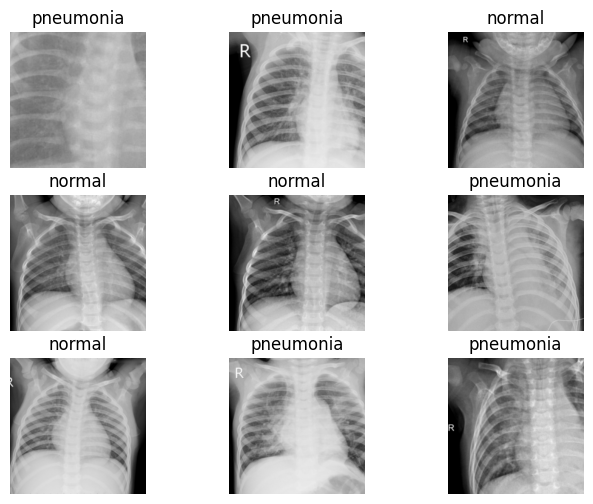

In [ ]:
from matplotlib.typing import path
# Set up a new DataBlock for 2-class classification (Normal, Pneumonia)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    # This applies the lambda function to each DataFrame row
    get_x=ColReader('orig_file_path', pref=PROJECT_PATH + '/'),
    get_y=ColReader('image_class'),
    item_tfms=Resize(224)
)

# Create DataLoaders for the 2-class classification task
dls = dblock.dataloaders(df)
print("Image classification - pneumonia or normal")
dls.show_batch(figsize=(8, 6))

Sample images illustrate clear visual differences between normal lungs and those with pneumonia. Pneumonia images typically show areas of opacity or cloudiness, whereas normal images display clear lung fields.

Pneumonia image sub classification: viral and bacterial


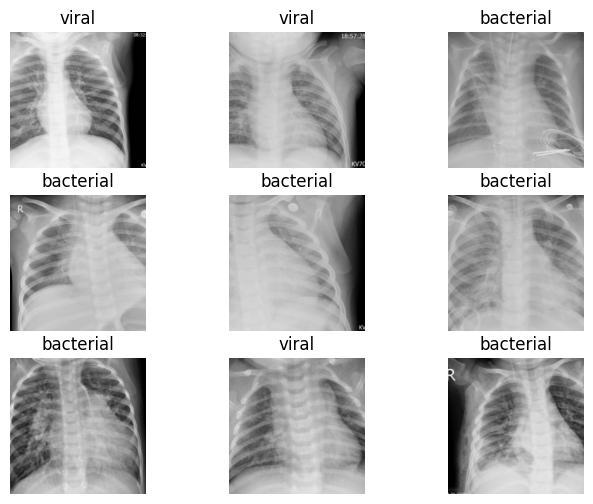

In [ ]:
# Create a DataFrame for pneumonia images
df_pneumonia = df[df['image_class'] == 'pneumonia']

# Set up a new DataBlock for 2-sub classification (Bacterial, Viral)
dblock_sub = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('orig_file_path', pref=PROJECT_PATH + '/'),
    get_y=ColReader('image_subclass'),
    item_tfms=Resize(224)
)

# Create DataLoaders for the 3-class classification task
dls_sub = dblock_sub.dataloaders(df_pneumonia)

print("Pneumonia image sub classification: viral and bacterial")

dls_sub.show_batch(figsize=(8, 6))

Viral and bacterial pneumonia often look quite similar in X-ray images, with differences that are subtle and harder to spot.

### Calculate image statistics

In this step, we calculate image statistics like contrast, entropy, and signal-to-noise ratio for every X-ray in our dataset. This allows us to evaluate image quality, spot noisy or low-quality examples, and gain insights into differences between normal and pneumonia cases to improve our data cleaning and modeling.

In [ ]:
from pathlib import Path
import seaborn as sns
import random
from collections import Counter
import os

image_classes = df['image_class'].unique()
image_subclasses = df['image_subclass'].dropna().unique()
metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']
metrics_file = os.path.join(DATA_PATH, 'xray_images_metrics.csv')

# Check if metrics file exists
if os.path.exists(metrics_file):
    print(f"Loading metrics from {metrics_file}")
    df_metrics = pd.read_csv(metrics_file)
else:
    # Use all available CPUs
    num_cores = multiprocessing.cpu_count()
    print("\nNumber of available CPUs",num_cores)
    print("\n\n Compute Image Statistics...")
    results = Parallel(n_jobs=num_cores)(
        delayed(compute_metrics_with_transform)(f) for f in df['orig_file_path']
    )

    df_metrics = pd.DataFrame(results)
    #Save the DataFrame with metrics
    df_metrics.to_csv(metrics_file, index=False)
    print(f"Metrics computed and saved to {metrics_file}")

df = df.merge(df_metrics, on='orig_file_path', how='left')
df.head()


Loading metrics from /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data/xray_images_metrics.csv


,orig_file_path,file_name,image_class,image_subclass,usage_type,mean,contrast,entropy,signal_noise_ratio,width,height
0,data/chest_xray/test/NORMAL/IM-0001-0001.jpeg,IM-0001-0001.jpeg,normal,None,test,130.998608,57.102032,7.623622,2.294115,1857,1317
1,data/chest_xray/test/NORMAL/IM-0003-0001.jpeg,IM-0003-0001.jpeg,normal,None,test,142.445303,60.668227,7.627586,2.347939,2111,1509
2,data/chest_xray/test/NORMAL/IM-0005-0001.jpeg,IM-0005-0001.jpeg,normal,None,test,136.249559,55.404084,7.594997,2.459197,2031,1837
3,data/chest_xray/test/NORMAL/IM-0006-0001.jpeg,IM-0006-0001.jpeg,normal,None,test,148.670080,42.324957,7.350563,3.512587,1663,1326
4,data/chest_xray/test/NORMAL/IM-0007-0001.jpeg,IM-0007-0001.jpeg,normal,None,test,137.699779,53.966271,7.659481,2.551590,2053,1818


### Plot image statistics

In this section, we plot the calculated image statistics to visualize quality and feature differences across the dataset

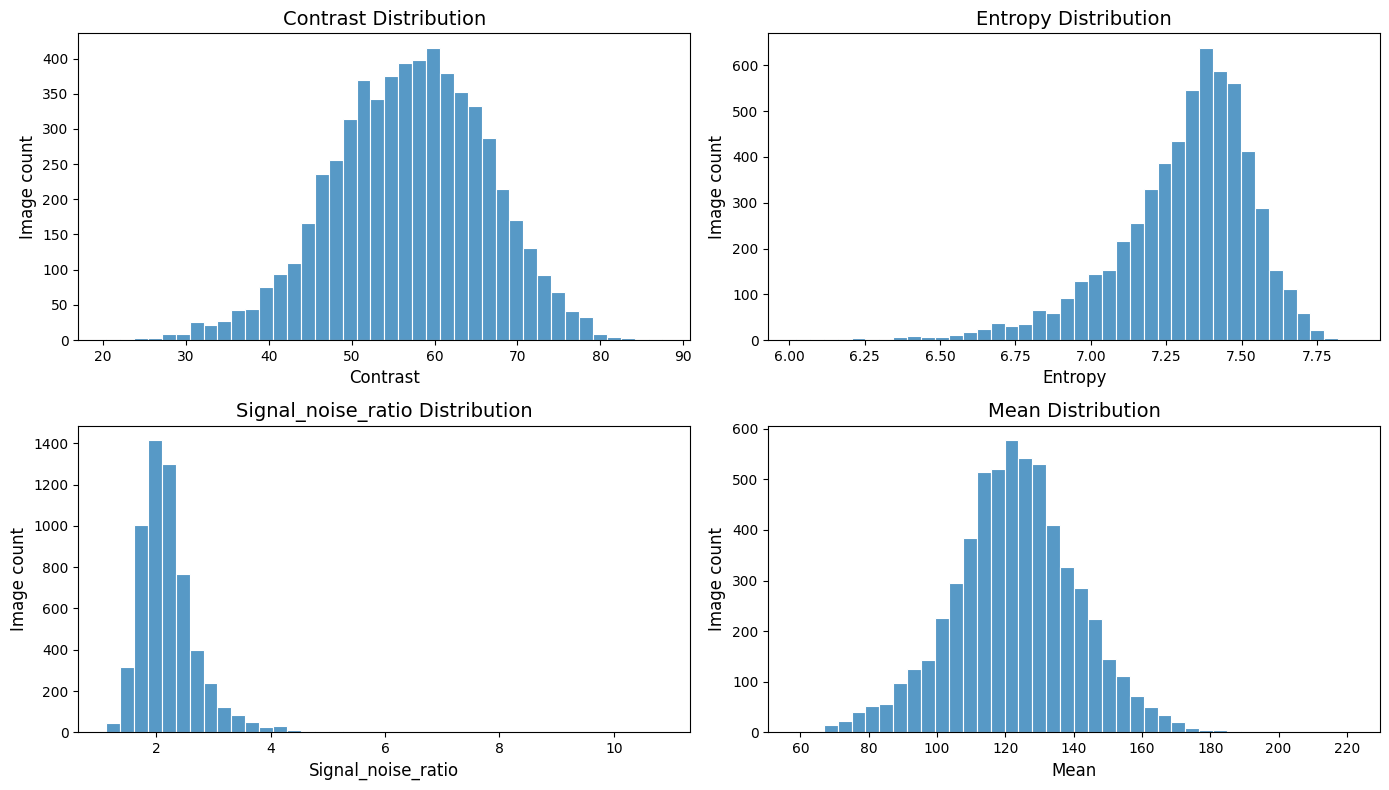

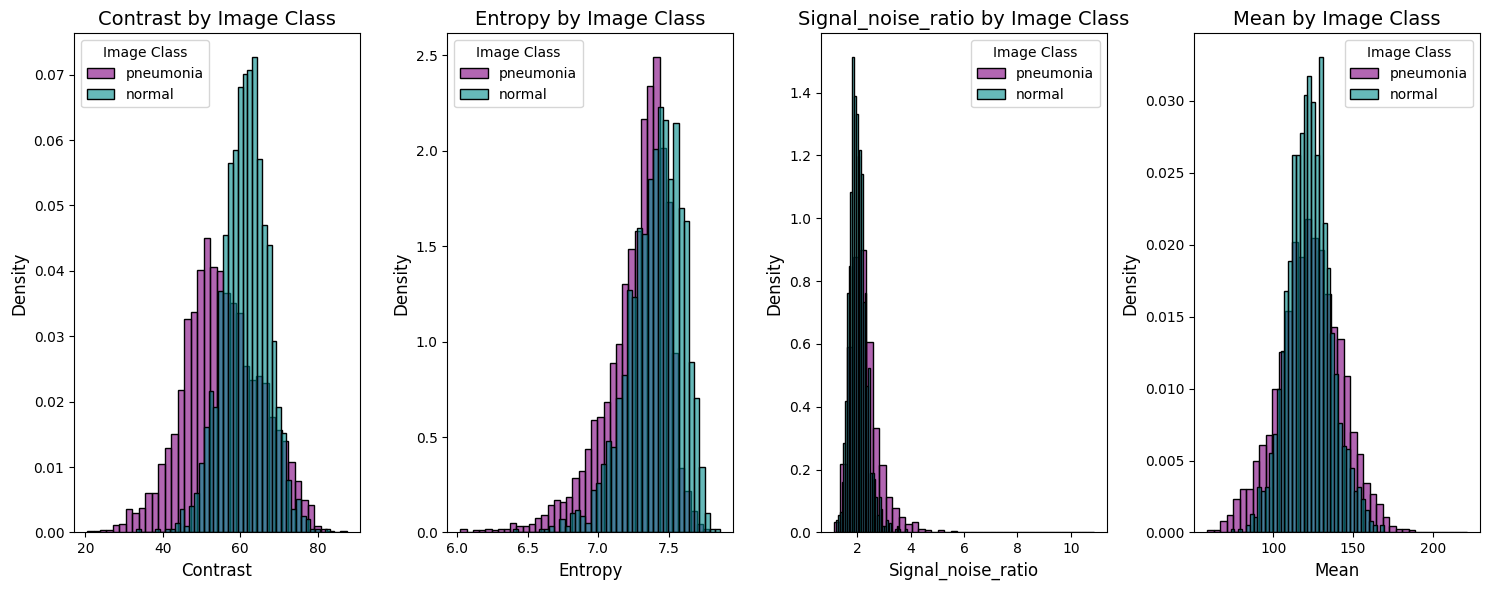

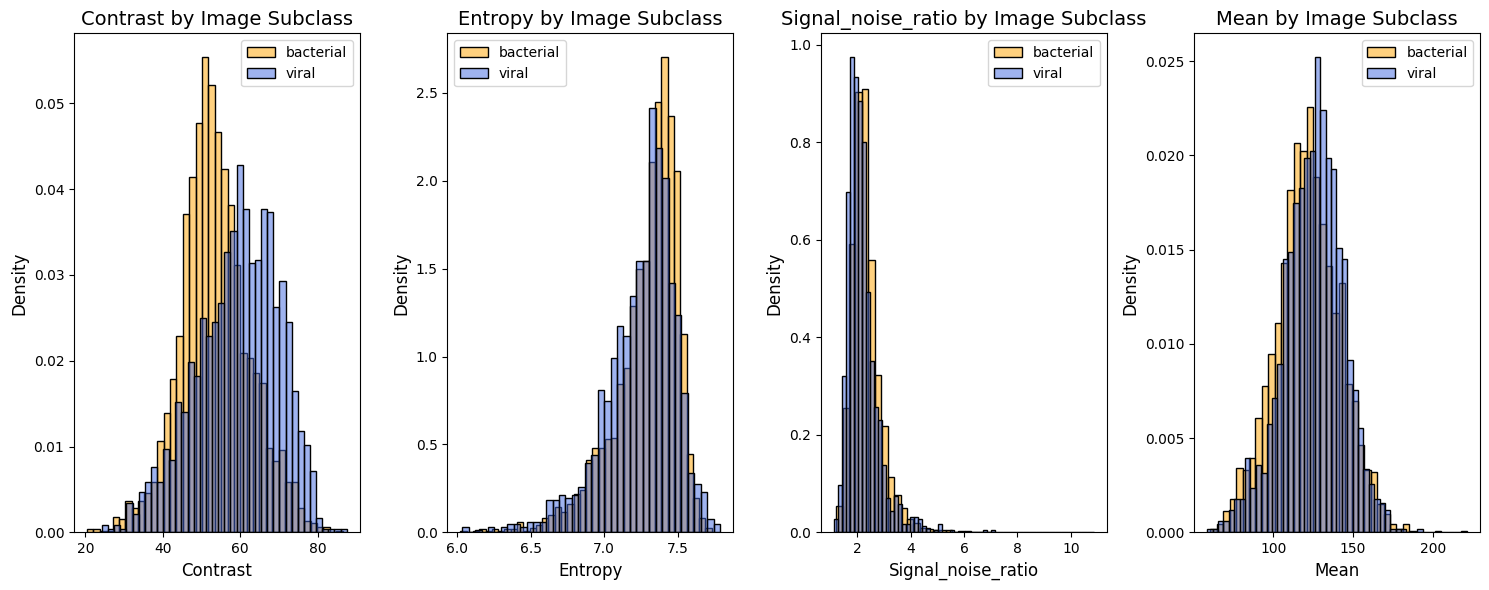

In [ ]:
#Plot diagrams for each metric
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for i in range(len(metrics)):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        df[metrics[i]].dropna(),
        bins=40,
        edgecolor='white'
    )
    plt.title(f'{metrics[i].capitalize()} Distribution', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Image count', fontsize=12)
plt.tight_layout()
plt.show()


# Plot diagrams for each image-class
class_color_map = {
    'pneumonia': 'purple', # bold red
    'normal': 'darkcyan',    # teal/green
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in ['pneumonia', 'normal']:
        vals = df[df['image_class'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.6,
            linewidth=1,
            stat = 'density',
            common_norm=False,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Class', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Image Class')
plt.tight_layout()
plt.show()

# Plot diagrams for each image-subclass
class_color_map = {
    'bacterial': 'orange',
    'viral': 'royalblue',
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in image_subclasses:
        vals = df[df['image_subclass'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.5,
            linewidth=1,
            stat = 'density',
            common_norm=False,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Subclass', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()

Across image classes histograms display moderate values for contrast, entropy, and mean, with a right-skewed signal-to-noise ratio(snr) indicating a few unusually clean scans. Outliers with very low contrast or mean highlight indicating low quality images.For pneumonia vs normal. Pneumonia images tend to have slightly higher average contrast and entropy than normal ones, though the distributions substantially overlap. Viral and bacterial pneumonia images show very similar distributions across all metrics, with only subtle differences detected like viral images have slightly better contrast.


### Identify and remove low quality images

**Identify small images**

---



Our pre-trained model uses 244x244 image size. We will remove images smaller than that size.

In [ ]:
## Identify smaller images than ImageNet(244)
size_threshold = 244
small_img = df[(df['width'] < size_threshold) | (df['height'] < size_threshold)]
small_img.describe()


,mean,contrast,entropy,signal_noise_ratio,width,height
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,132.656973,45.955423,7.002872,2.999987,470.711538,191.865385
std,15.740903,8.647248,0.277183,0.780958,39.086298,30.943990
min,71.142924,27.907264,6.362827,1.930794,384.000000,127.000000
25%,122.345411,40.335480,6.856465,2.522469,445.000000,172.750000
50%,134.517138,45.055093,7.034936,2.882159,464.500000,189.500000
75%,142.962274,52.096492,7.203138,3.171104,492.500000,218.250000
max,172.314810,67.581674,7.472790,5.536823,564.000000,242.000000


**Remove low quality images**

Remove low contrast and small images from the dataset

In [ ]:
print("\nTotal number of images to remove",len(small_img))
df_clean = df[~df['orig_file_path'].isin(small_img['orig_file_path'])]
df_clean =  df_clean.reset_index(drop=True)


Total number of images to remove 52


Save dataset after removal of low quality images

In [ ]:
df_clean.to_csv(os.path.join(DATA_PATH, 'df_clean.csv'),index=False)

df_clean.info()

df_clean.groupby(['usage_type', 'image_class', 'image_subclass'], dropna=False)['orig_file_path'].count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804 entries, 0 to 5803
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   orig_file_path      5804 non-null   object 
 1   file_name           5804 non-null   object 
 2   image_class         5804 non-null   object 
 3   image_subclass      4221 non-null   object 
 4   usage_type          5804 non-null   object 
 5   mean                5804 non-null   float64
 6   contrast            5804 non-null   float64
 7   entropy             5804 non-null   float64
 8   signal_noise_ratio  5804 non-null   float64
 9   width               5804 non-null   int64  
 10  height              5804 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 498.9+ KB


usage_type  image_class  image_subclass
test        normal       NaN                234
            pneumonia    bacterial          242
                         viral              148
train       normal       NaN               1349
            pneumonia    bacterial         2508
                         viral             1323
Name: orig_file_path, dtype: int64

Plot histograms after low quality images removal

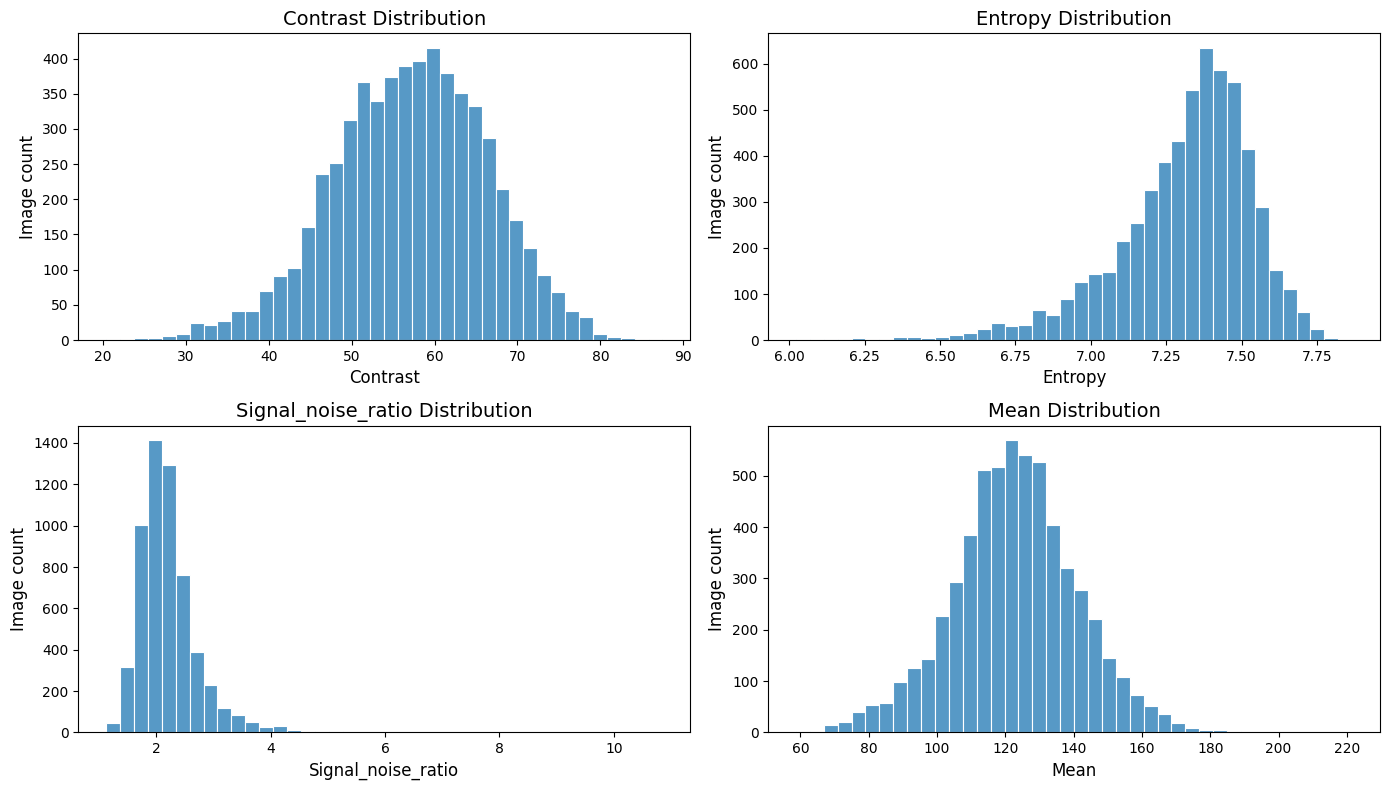

In [ ]:
plt.figure(figsize=(14, 8))
for i in range(len(metrics)):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        df_clean[metrics[i]].dropna(),
        bins=40,
        edgecolor='white'
    )
    plt.title(f'{metrics[i].capitalize()} Distribution', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Image count', fontsize=12)
plt.tight_layout()
plt.show()

We can observe that distribution did not change after removing low quality images, which means that we did not impact image statistics distribution. Next we will prepare data for pneumonia detection model training.

## Prepare and analyze training data
In this section, we create two training datasets by first converting all chest X-ray images from grayscale to RGB to match the input requirements of the pretrained ResNet50 model. For the first dataset, images are prepared without augmentation; for the second, we apply Contrast Limited Adaptive Histogram Equalization (CLAHE) preprocessing to enhance image contrast and quality. This approach allows us to compare model performance using standard versus improved image inputs, optimizing training for x-ray image classification.

***Note:
This section loads the pre-cleaned dataset generated earlier.
If you’ve already completed data cleaning in previous sections, you can start from here (after running the setup cell to load libraries and environment variables).***

In [ ]:
## Load cleaned images data
df_clean = pd.read_csv(os.path.join(DATA_PATH, 'df_clean.csv'))

# function to construct image path from image classification
def get_img_processed_dest_path(row, base_dir):
    parts = [
        base_dir,
        str(row['usage_type']),
        str(row['image_class']),
        str(row['file_name'])
    ]
    return os.path.join(*parts)




In [ ]:
# Group by usage_type, image_class, and image_subclass and count the filenames, including NaN values in the grouping
df_clean.groupby(['usage_type', 'image_class', 'image_subclass'], dropna=False)['file_name'].count()

usage_type  image_class  image_subclass
test        normal       NaN                234
            pneumonia    bacterial          242
                         viral              148
train       normal       NaN               1349
            pneumonia    bacterial         2508
                         viral             1323
Name: file_name, dtype: int64

***Note that there is significant imbalance between image classes and image subclasses. We will need to address that during model training***

### Set 1 preparation


For Training Set 1, we use the images that have only undergone grayscale conversion (no additional preprocessing or enhancement). This set provides a baseline for model training using the minimally processed, color-corrected chest X-ray images.

***There were images in dataset with RGB pallette and even with grayscale there could be various approaches. Using algorithm across all images ensure consistency***

In [ ]:
df_training_set1 = df_clean.copy()

#drop metrics to recalculate them after transformation
df_training_set1.drop(columns=['contrast', 'entropy','mean', 'signal_noise_ratio', 'width', 'height'], inplace=True)

df_training_set1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804 entries, 0 to 5803
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   orig_file_path  5804 non-null   object
 1   file_name       5804 non-null   object
 2   image_class     5804 non-null   object
 3   image_subclass  4221 non-null   object
 4   usage_type      5804 non-null   object
dtypes: object(5)
memory usage: 226.8+ KB


#### Compute statistics for set 1 with grayscale filter

In [ ]:
from pathlib import Path
import seaborn as sns
import random
from collections import Counter
import os

image_classes = df_training_set1['image_class'].unique()
image_subclasses = df_training_set1['image_subclass'].dropna().unique()
metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']
metrics_file_set1 = os.path.join(DATA_PATH, 'xray_images_metrics_set1.csv')

# Check if metrics file exists
if os.path.exists(metrics_file_set1):
    print(f"Loading metrics from {metrics_file_set1}")
    df_metrics_set1 = pd.read_csv(metrics_file_set1)
else:

    # Use all available CPUs
    num_cores = multiprocessing.cpu_count()
    print("\nNumber of available CPUs",num_cores)
    print("\n\n Compute Image Statistics...")
    tf = EnsureGrayscale()
    results = Parallel(n_jobs=num_cores)(
        delayed(compute_metrics_with_transform)(f, transforms=[tf])
        for f in df_training_set1['orig_file_path']
    )

    df_metrics_set1 = pd.DataFrame(results)

    # Save the DataFrame with metrics
    df_metrics_set1.to_csv(metrics_file_set1, index=False)
    print(f"Metrics computed and saved to {metrics_file_set1}")

df_training_set1 = df_training_set1.merge(df_metrics_set1, on='orig_file_path', how='left')
df_training_set1.head()

Loading metrics from /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data/xray_images_metrics_set1.csv


,orig_file_path,file_name,image_class,image_subclass,usage_type,mean,contrast,entropy,signal_noise_ratio,width,height
0,data/chest_xray/test/NORMAL/IM-0001-0001.jpeg,IM-0001-0001.jpeg,normal,NaN,test,130.735686,57.106981,7.265963,2.289312,1857,1317
1,data/chest_xray/test/NORMAL/IM-0003-0001.jpeg,IM-0003-0001.jpeg,normal,NaN,test,142.187266,60.665415,7.283907,2.343795,2111,1509
2,data/chest_xray/test/NORMAL/IM-0005-0001.jpeg,IM-0005-0001.jpeg,normal,NaN,test,135.989814,55.403034,7.246311,2.454555,2031,1837
3,data/chest_xray/test/NORMAL/IM-0006-0001.jpeg,IM-0006-0001.jpeg,normal,NaN,test,148.415087,42.322906,7.010260,3.506732,1663,1326
4,data/chest_xray/test/NORMAL/IM-0007-0001.jpeg,IM-0007-0001.jpeg,normal,NaN,test,137.443083,53.962186,7.308609,2.547026,2053,1818


In [ ]:
df_training_set1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804 entries, 0 to 5803
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   orig_file_path      5804 non-null   object 
 1   file_name           5804 non-null   object 
 2   image_class         5804 non-null   object 
 3   image_subclass      4221 non-null   object 
 4   usage_type          5804 non-null   object 
 5   mean                5804 non-null   float64
 6   contrast            5804 non-null   float64
 7   entropy             5804 non-null   float64
 8   signal_noise_ratio  5804 non-null   float64
 9   width               5804 non-null   int64  
 10  height              5804 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 498.9+ KB


#### Plot Training Set 1 statistics

In this section, we visualize the distributions of key image metrics for Training Set 1.



Training Set 1


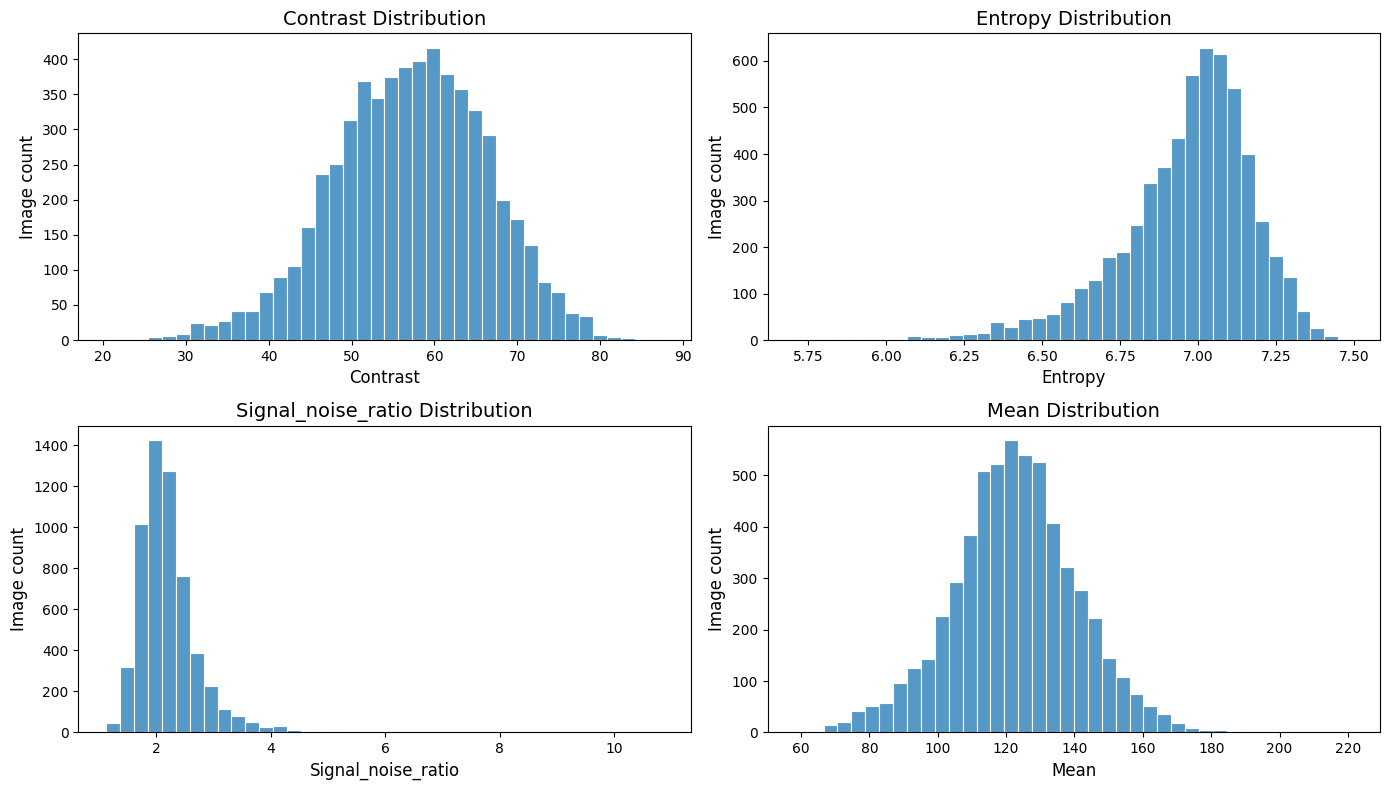

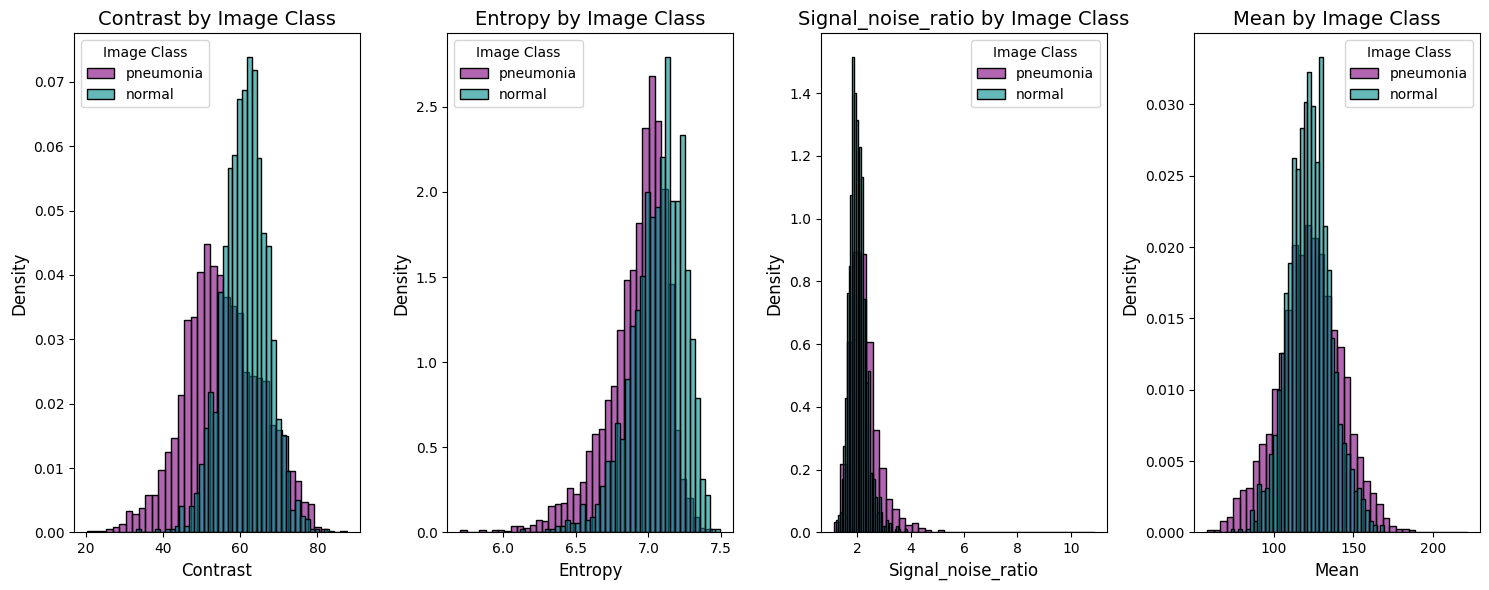

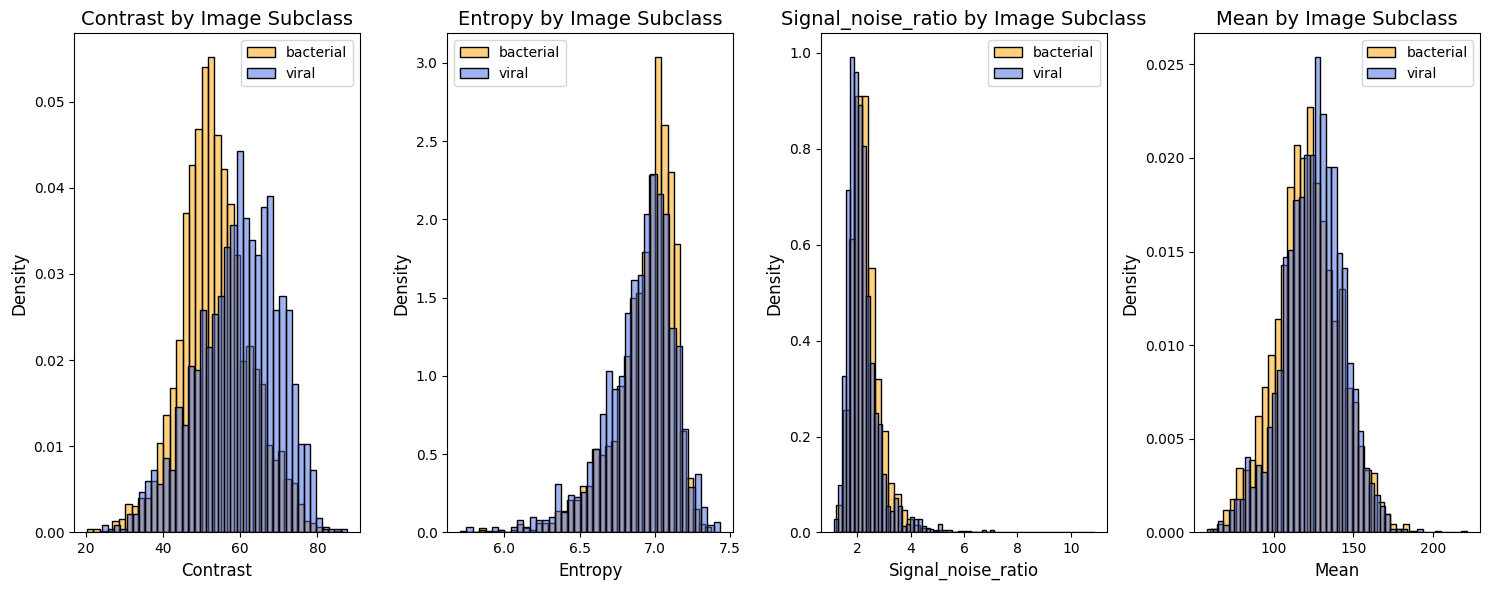

In [ ]:
#Plot diagrams for each metric
import seaborn as sns
import matplotlib.pyplot as plt


print("Training Set 1")
plt.figure(figsize=(14, 8))
for i in range(len(metrics)):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        df_training_set1[metrics[i]].dropna(),
        bins=40,
        edgecolor='white'
    )
    plt.title(f'{metrics[i].capitalize()} Distribution', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Image count', fontsize=12)
plt.tight_layout()
plt.show()


# Plot diagrams for each image-class
class_color_map = {
    'pneumonia': 'purple', # bold red
    'normal': 'darkcyan',    # teal/green
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in ['pneumonia', 'normal']:
        vals = df_training_set1[df_training_set1['image_class'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.6,
            stat = 'density',
            common_norm=False,
            linewidth=1,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Class', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Image Class')
plt.tight_layout()
plt.show()

# Plot diagrams for each image-subclass
class_color_map = {
    'bacterial': 'orange',
    'viral': 'royalblue',
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in image_subclasses:
        vals = df_training_set1[df_training_set1['image_subclass'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.5,
            stat = 'density',
            common_norm=False,
            linewidth=1,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Subclass', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()



After grayscale conversion and removing low quality images we can can observe significant overlap for image classifications across metrics. Contrast appear biggest differentior.

#### Save training set 1 data frame

In [ ]:
df_training_set1.to_csv(os.path.join(DATA_PATH, 'df_training_set1.csv'),index=False)

### Set 2 preparation

**Training Set 2** will use grayscale conversion and apply [Contrast Limited Adaptive Histogram Equalization (CLAHE)](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) to each image to improve local contrast. Additionally, the [Hot colormap](https://pmc.ncbi.nlm.nih.gov/articles/PMC5148121/) will be applied to further enhance differentiation of features in the images. This combined approach aims to optimize contrast distribution and highlight important patterns within the chest X-rays.


#### Compute statistics with applied CLAHE and Hot Colormap

In [ ]:
#configure image transformation classes

df_training_set2 = df_clean.copy()
metrics_file_set2 = os.path.join(DATA_PATH, 'xray_images_metrics_set2.csv')

#drop metrics to replace them with metrics for clahe
df_training_set2.drop(columns=['contrast', 'entropy','mean', 'signal_noise_ratio', 'width', 'height'], inplace=True)

if os.path.exists(metrics_file_set2):
    print(f"Loading metrics from {metrics_file_set2}")
    df_metrics_set2 = pd.read_csv(metrics_file_set2)
else:
    num_cores = multiprocessing.cpu_count()
    print(f"\nCPUs available: {num_cores}")

    print("\nCompute image statistics with CLAHE...")

    results = Parallel(n_jobs=num_cores)(
        delayed(compute_metrics_with_transform)(
            f,
            transforms=[EnsureGrayscale(), GrayscaleCLAHE(df_clean), ColormapEnhancement()]
        )
        for f in df_training_set2['orig_file_path']
    )

    df_metrics_set2 = pd.DataFrame(results)
    df_metrics_set2.to_csv(metrics_file_set2, index=False)
    print(f"Metrics saved to {metrics_file_set2}")

df_training_set2 = df_training_set2.merge(df_metrics_set2, on='orig_file_path', how='left')
df_training_set2.head()

Loading metrics from /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data/xray_images_metrics_set2.csv


,orig_file_path,file_name,image_class,image_subclass,usage_type,mean,contrast,entropy,signal_noise_ratio,width,height
0,data/chest_xray/test/NORMAL/IM-0001-0001.jpeg,IM-0001-0001.jpeg,normal,NaN,test,117.961912,70.935172,7.535515,1.662954,1857,1317
1,data/chest_xray/test/NORMAL/IM-0003-0001.jpeg,IM-0003-0001.jpeg,normal,NaN,test,128.261761,72.839031,7.532657,1.760893,2111,1509
2,data/chest_xray/test/NORMAL/IM-0005-0001.jpeg,IM-0005-0001.jpeg,normal,NaN,test,124.704067,71.393380,7.560612,1.746718,2031,1837
3,data/chest_xray/test/NORMAL/IM-0006-0001.jpeg,IM-0006-0001.jpeg,normal,NaN,test,136.341304,64.090955,7.405120,2.127310,1663,1326
4,data/chest_xray/test/NORMAL/IM-0007-0001.jpeg,IM-0007-0001.jpeg,normal,NaN,test,124.624939,70.550699,7.554565,1.766459,2053,1818


#### Plot training set 2 with applied enhancements

Plot image metrics distributions with comparison between image classifications

Training Set 2


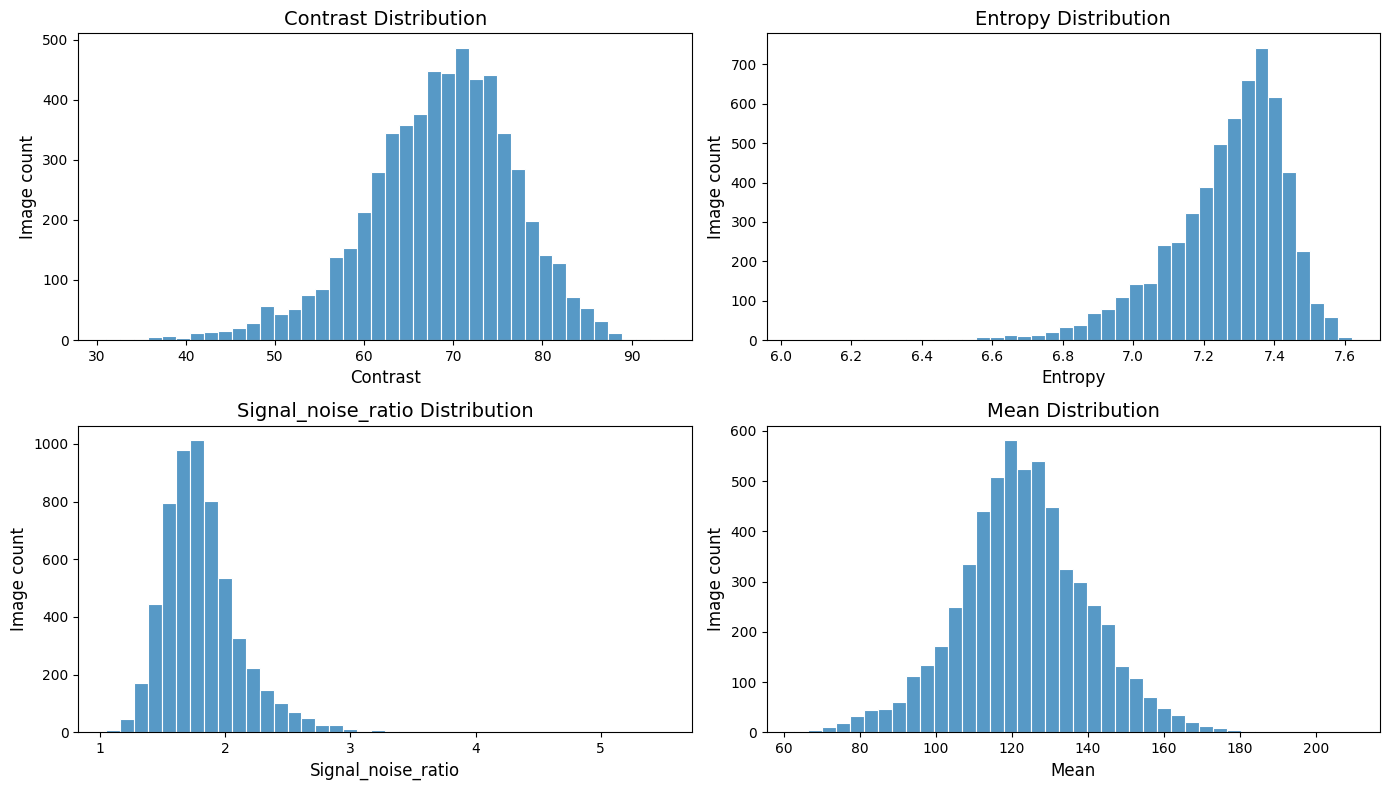

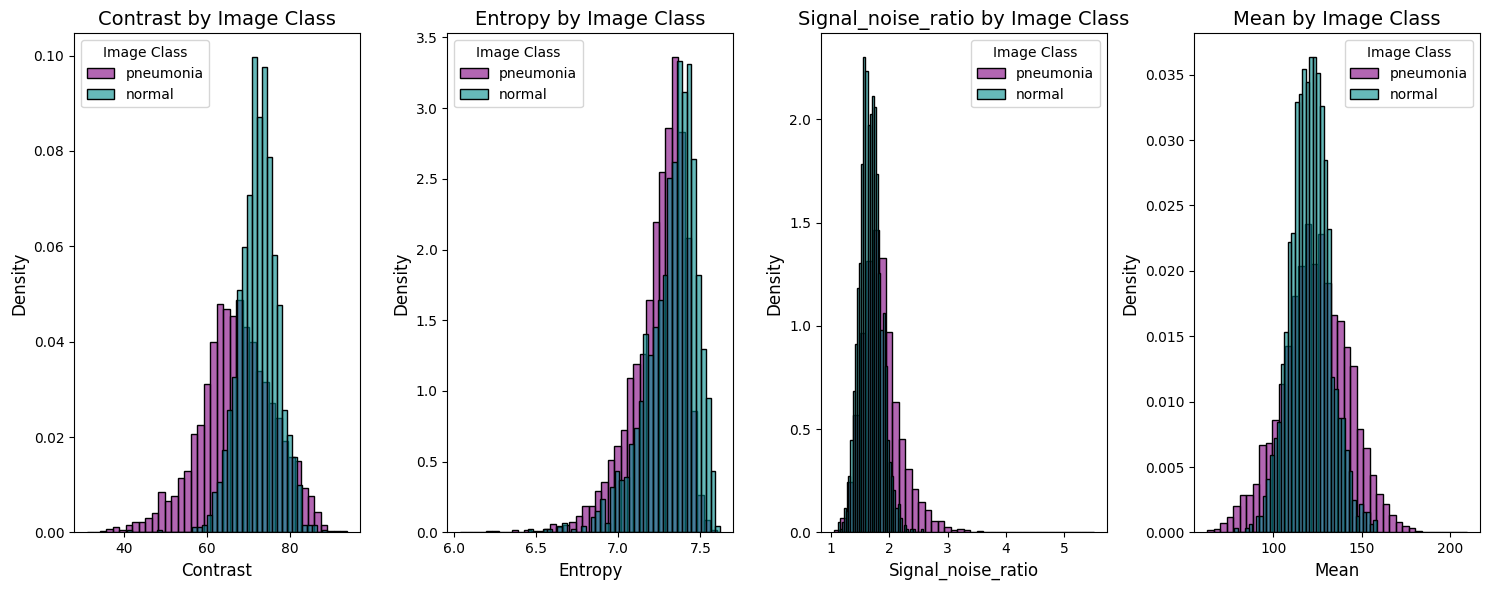

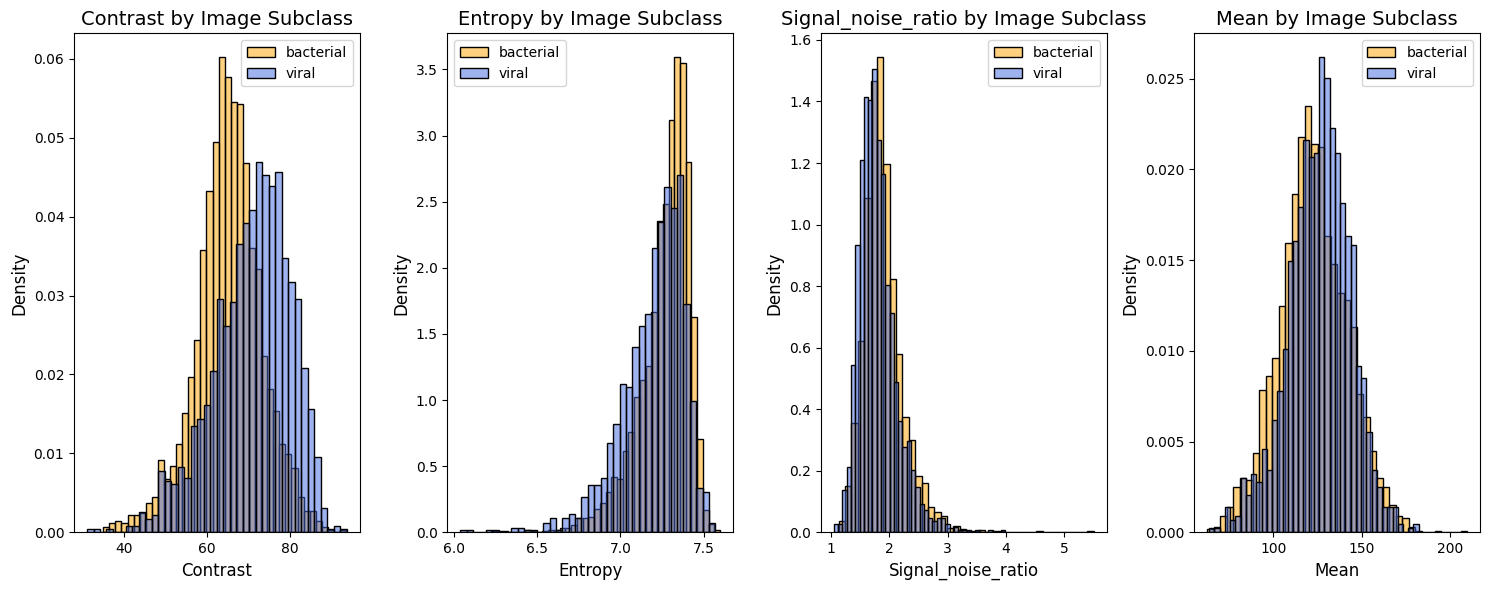

In [ ]:
#Plot diagrams for each metric
import seaborn as sns
import matplotlib.pyplot as plt

print("Training Set 2")
plt.figure(figsize=(14, 8))
for i in range(len(metrics)):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        df_training_set2[metrics[i]].dropna(),
        bins=40,
        edgecolor='white'
    )
    plt.title(f'{metrics[i].capitalize()} Distribution', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Image count', fontsize=12)
plt.tight_layout()
plt.show()


# Plot diagrams for each image-class
class_color_map = {
    'pneumonia': 'purple', # bold red
    'normal': 'darkcyan',    # teal/green
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in ['pneumonia', 'normal']:
        vals = df_training_set2[df_training_set2['image_class'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.6,
            linewidth=1,
            stat = 'density',
            common_norm=False,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Class', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Image Class')
plt.tight_layout()
plt.show()

# Plot diagrams for each image-subclass
class_color_map = {
    'bacterial': 'orange',
    'viral': 'royalblue',
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in image_subclasses:
        vals = df_training_set2[df_training_set2['image_subclass'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.5,
            linewidth=1,
            stat = 'density',
            common_norm=False,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Subclass', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()



Applying CLAHE and the Inferno colormap to grayscale chest X-ray images significantly increases image contrast and entropy across both normal and pneumonia image classes and subclasses.

#### Show sample images enhanced with CLAHE and Inferno colormap

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

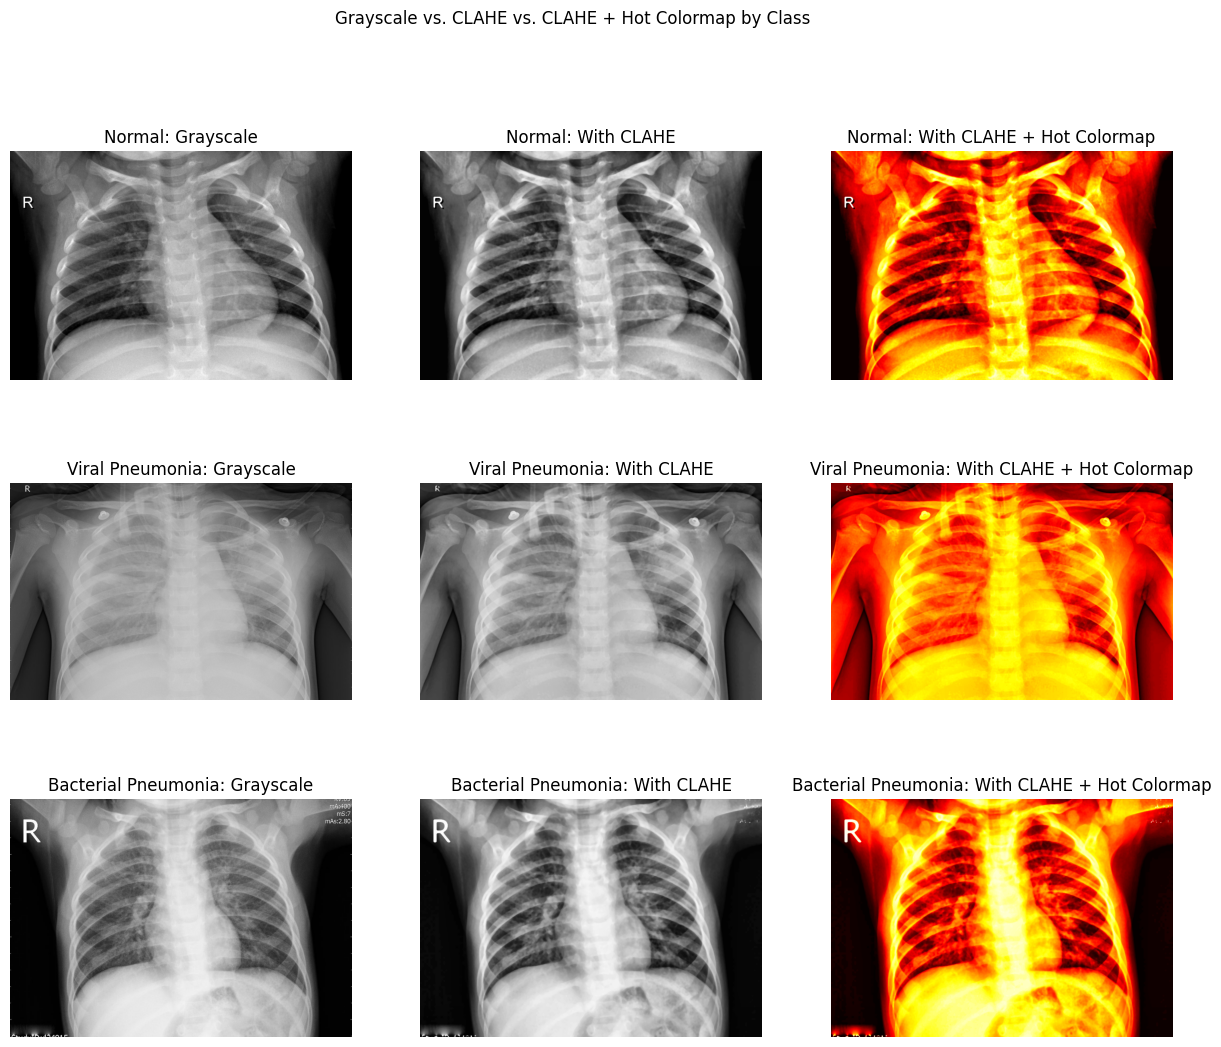

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Select one random normal image
sample_normal = df_training_set2[df_training_set2['image_class'] == 'normal'].sample(1).iloc[0]

# Select one random bacterial image from pneumonia class
sample_bacterial = df_training_set2[
    (df_training_set2['image_class'] == 'pneumonia') &
    (df_training_set2['image_subclass'] == 'bacterial')
].sample(1).iloc[0]

# Select one random viral image from pneumonia class
sample_viral = df_training_set2[
    (df_training_set2['image_class'] == 'pneumonia') &
    (df_training_set2['image_subclass'] == 'viral')
].sample(1).iloc[0]

samples = [sample_normal, sample_viral, sample_bacterial]
class_names = ['Normal', 'Viral Pneumonia', 'Bacterial Pneumonia']

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Grayscale vs. CLAHE vs. CLAHE + Hot Colormap by Class")

for i, sample in enumerate(samples):
    img_path = image_absolute_path_function(sample['orig_file_path'])
    img_pil = Image.open(img_path)
    img_pil.fname = img_path
    # Grayscale (EnsureGrayscale)
    img_gray, =  EnsureGrayscale().encodes((img_pil,))
    axs[i, 0].imshow(img_gray, cmap='gray')
    axs[i, 0].set_title(f"{class_names[i]}: Grayscale")
    axs[i, 0].axis('off')

    img_gray.fname = img_path

    # CLAHE
    img_clahe, = GrayscaleCLAHE(df_training_set2).encodes((img_gray,))
    axs[i, 1].imshow(img_clahe, cmap='gray')
    axs[i, 1].set_title(f"{class_names[i]}: With CLAHE")
    axs[i, 1].axis('off')

    # CLAHE + Colormap (Inferno)
    img_colormap, = ColormapEnhancement().encodes((img_clahe,))
    axs[i, 2].imshow(img_colormap)
    axs[i, 2].set_title(f"{class_names[i]}: With CLAHE + Hot Colormap")
    axs[i, 2].axis('off')

plt.tight_layout


#### Save Training set 2 data frame

In [ ]:
df_training_set2.to_csv(os.path.join(DATA_PATH, 'df_training_set2.csv'),index=False)

## Model Preparation and Training


We apply deep learning to classify chest X-ray images as normal, viral pneumonia, or bacterial pneumonia. Rather than building a neural network from scratch, we leverage **transfer learning** using the ResNet-50 architecture, which has been pretrained on the extensive [ImageNet dataset](https://www.image-net.org/). This approach allows us to reuse model image classification capabilities and efficiently fine-tune the model with our x-ray images.

<img src="https://storage.googleapis.com/kaggle-datasets-images/6978/10038/d9e74a548a8cdca167b38520ac8bf405/data-original.png?t=2017-12-13-20-32-53" width="450" alt="ResNet Example">

We train model version of [ResNet-50](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) to distinguish both general pneumonia and its subtypes using chest X-ray images from the [Kaggle Chest X-Ray Images (Pneumonia) dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

Our image sets are prepared with the following enhancements:
- **Grayscale conversion** to standardize input.
- **CLAHE preprocessing** ([method](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization)) is applied to improve local contrast.
- **Hot colormap application** ([details](https://pmc.ncbi.nlm.nih.gov/articles/PMC5148121/)) further enhances feature differentiation, making anatomical and pathological regions more visible.

**Note:** This section uses the saved training sets created in the previous section. If your training sets are already prepared, you can start from here after running the setup.



### Training model and validation

We use a two-stage ResNet-50 model pretrained on [ImageNet](https://www.image-net.org/).

- **Stage 1** detects pneumonia vs normal cases.
- **Stage 2** classifies pneumonia cases as viral or bacterial.

Training uses transfer learning, the F1-score metric, and both standard grayscale images and CLAHE-preprocessed images with Hot colormap enhancement for best results.



#### Training Set 1 - Two Stage Training

In Training Set 1, we use the minimally processed RGB chest X-ray images to train a hierarchical two-stage classification pipeline. The first model detects pneumonia vs normal cases; the second model further classifies pneumonia as viral or bacterial.

#####  Load training images dataset

In [31]:
## Load cleaned images data
df_clean = pd.read_csv(os.path.join(DATA_PATH, 'df_clean.csv'))

df_training_set1 = pd.read_csv(os.path.join(DATA_PATH, 'df_training_set1.csv'))


##### Stage 1 Training - Normal vs Pneumonia

For the **first-stage model**, we perform binary classification (normal vs. pneumonia) and select the best performing model based on [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).
This approach prioritizes **sensitivity** (recall), aiming to minimize missed pneumonia cases—even if it results in more false positives.

**Training Set 1** is preprocessed using only grayscale conversion and standard normalization.


In [30]:
df_set1_train = df_training_set1[df_training_set1['usage_type'] == 'train'].copy()
df_set1_train = df_set1_train.reset_index(drop=True)


# split train and validation data proportionally across classes with shuffle
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(df_set1_train, df_set1_train['image_class']))

df_set1_train['is_validation'] = False
df_set1_train.loc[val_idx, 'is_validation'] = True

dls_set1_stage1 = ImageDataLoaders.from_df(
    df_set1_train,
    path=PROJECT_PATH,
    fn_col='orig_file_path',
    label_col='image_class',
    valid_col='is_validation',
    item_tfms=[EnsureGrayscale(), Resize(224)],
    batch_tfms=[*aug_transforms(
        do_flip=True, max_rotate=5,
        max_lighting=0.1, p_lighting=0.75
        ),
        Normalize.from_stats(*imagenet_stats)],
    num_workers=8,
    bs=64
)

# Increase weigths for smaller set of normal cases to have better balance
weights = torch.tensor([1.5, 1.0], device=dls_set1_stage1.device)
loss_func = CrossEntropyLossFlat(weight=weights)

learn_set1_stage1 = vision_learner(
    dls_set1_stage1,
    resnet50,
    pretrained=True,
    loss_func=loss_func,
    metrics=[error_rate, F1Score(average='binary'), Precision(average='binary'), Recall(average='binary')],
    cbs=[
        SaveModelCallback(monitor='f1_score', comp=np.greater, with_opt=True),
        EarlyStoppingCallback(monitor='valid_loss', patience=3) #avoid over training
    ]
)

learn_set1_stage1.path = Path(MODEL_PATH)

KeyboardInterrupt: 

Here we will train ResNet-50 model pre-trained on imagenet.

In [ ]:
# STAGE 1 - Normal vs Pneumonia
learn_set1_stage1.fit_one_cycle(4)
learn_set1_stage1.unfreeze()
learn_set1_stage1.fit_one_cycle(8)

The results demonstrated high performance with an F1-score above 0.95 on average.

###### Validate Stage 1 results

After training, we reload the best saved model and recalculate metrics on the validation set for an accurate assessment. We then use the confusion matrix to examine how many images are misclassified.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_set1_stage1)
results = learn_set1_stage1.validate()
val_loss, val_error, val_f1, val_precision, val_recall = results
print(f"Validation Accuracy: {1 - val_error:.4f}")
print(f"Validation metrics: Loss={val_loss:.4f}, F1={val_f1:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}")



The final validation results are calculated using the best saved model weights. This approach produced F1 ≈ 0.99, precision ≈ 0.99, and recall ≈ 0.98.

**Confusion Matrix**

In [ ]:
interp.plot_confusion_matrix()

The confusion matrix shows that only a small number of images were misclassified with higher precision (false-positive) over recall (false-negatives).

**Top Losses Analysis**

In [ ]:
plt.tight_layout()
interp.plot_top_losses(9, figsize=(12,12))

Several concerning examples were misclassified with high confidence (probabilities 1.0).



###### Save trained model

After training, we reload the best model checkpoint and export the trained model. Additionally, the backbone weights are saved separately for use in stage 2, allowing transfer learning for pneumonia subtype classification.

In [ ]:
learn_set1_stage1.load('model')  # Loads the best checkpoint
# Save model for inference
learn_set1_stage1.export(os.path.join(MODEL_PATH, 'set1_pneumonia_detector.pkl'))

# Save backbone only for stage 2 training
torch.save(
    learn_set1_stage1.model[0].state_dict(),
    Path(MODEL_PATH) / 'set1_pneumonia_detector_backbone.pth'
)

##### Stage 2 Training - Pneumonia Viral vs Pneumonia Bacterial

For stage 2, the model focuses on distinguishing bacterial vs. viral pneumonia among images already identified as pneumonia in stage 1. We leverage the trained backbone from stage 1.

Here, we use the pretrained pneumonia detection backbone to classify pneumonia cases into bacterial or viral subtypes. Training uses a narrow range of learning rates for this more detailed classification.

In [ ]:
suggested_lr = learn_set1_stage2.lr_find(show_plot=False).valley
print("Learning rate suggested by Fast AI ",suggested_lr)

learn_set1_stage2.fit_one_cycle(6, lr_max=suggested_lr/2.0)  # Fine-tune the head
learn_set1_stage2.unfreeze()
learn_set1_stage2.fit_one_cycle(12, lr_max=slice(suggested_lr/100.0, suggested_lr/10.0))  # Refine features



The bacterial vs. viral pneumonia classifier, trained with balanced class weights and F1-score monitoring, achieved moderate performance, with best validation F1-score reaching ~0.72 and recall up to ~0.71 during training.

###### Validate Stage 2 results

In [ ]:


# Filter dataframes for pneumonia images only
df_set1_train_pneumonia = df_set1_train[df_set1_train['image_class']=='pneumonia'].copy()
df_set1_train_pneumonia = df_set1_train_pneumonia.reset_index(drop=True)


# split train and validation data proportionally across classes with shuffle
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(df_set1_train_pneumonia, df_set1_train_pneumonia['image_class']))

df_set1_train_pneumonia['is_validation'] = False
df_set1_train_pneumonia.loc[val_idx, 'is_validation'] = True

#prioritize hardest images
focal_loss = FastFocalLoss(alpha=0.25, gamma=2.0)

# DataLoaders for subclassification (bacterial vs viral)
dls_set1_stage2 = ImageDataLoaders.from_df(
    df_set1_train_pneumonia,
    path=PROJECT_PATH,
    fn_col='orig_file_path',
    label_col='image_subclass',
    valid_col='is_validation',
    item_tfms=[EnsureGrayscale(),Resize(224)],
    loss_func=focal_loss,
    batch_tfms=[*aug_transforms(
        do_flip=True, max_rotate=5,
        max_lighting=0.1, p_lighting=0.75
        ),
        Normalize.from_stats(*imagenet_stats)],
    num_workers=8,
    vocab= image_subclasses,
    bs=64
)

learn_set1_stage2 = vision_learner(
    dls_set1_stage2,
    resnet50,
    pretrained = False,
    metrics=[error_rate, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')],
    cbs=[
        SaveModelCallback(monitor='f1_score', comp=np.greater, with_opt=True),
        EarlyStoppingCallback(monitor='valid_loss', patience=5)
    ]
)

learn_set1_stage2.path = Path(MODEL_PATH)

# Load the pneumonia trained model
learn_set1_stage2.model[0].load_state_dict(
    torch.load(Path(MODEL_PATH) / 'set1_pneumonia_detector_backbone.pth')
)

#classes = np.array(['viral', 'bacterial'])
#labels = df_set1_train_pneumonia['image_subclass'].tolist()
#class_weights = compute_class_weight('balanced', classes=classes, y=labels)

#learn_set1_stage2.loss_func = CrossEntropyLossFlat(
 #   weight=torch.tensor(class_weights, dtype=torch.float).to(learn_set1_stage2.dls.device)
#)


After training, we reload the best saved model and recalculate metrics on the validation set for an accurate assessment. We then use the confusion matrix to examine how many images are misclassified.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_set1_stage2)
results = learn_set1_stage2.validate()
val_loss, val_error, val_f1, val_precision, val_recall = results
print(f"Validation Accuracy: {1 - val_error:.4f}")
print(f"Validation metrics: Loss={val_loss:.4f}, F1={val_f1:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}")


The final validation results are calculated using the best saved model weights for subtype classification. This approach produced an F1-score of approximately 0.76, with precision ≈ 0.76 and recall ≈ 0.71, confirming moderate—performance for bacterial vs. viral pneumonia detection.

**Confusion Matrix**

In [ ]:
interp.plot_confusion_matrix()

The model more reliably detects bacterial pneumonia, but confuses 139 viral cases as bacterial and 55 bacterial cases as viral.

**Top Losses Analysis**

In [ ]:
plt.tight_layout()
interp.plot_top_losses(9, figsize=(12,12))

Several concerning examples were misclassified with high confidence (probabilities above 0.9). These errors are most common in zoomed-in, low-contrast images.

###### Save trained model

We will save trained model for further testing.

In [ ]:
learn_set1_stage2.load('model')  # Loads the best checkpoint
# Save Stage 2 model for iference
learn_set1_stage2.export(os.path.join(MODEL_PATH, 'set1_stage2_bacterial_viral_detector.pkl'))


#### Training Set 2 - Two-Stage Classification with CLAHE Preprocessing

In Training Set 2, we enhanced chest X-ray images using Contrast Limited Adaptive Histogram Equalization (CLAHE) to improve contrast and highlight image details. This set will use the same hierarchical two-stage classification pipeline as Set 1.

#####  Load training images dataset

In [32]:
## Load cleaned images data
df_clean = pd.read_csv(os.path.join(DATA_PATH, 'df_clean.csv'))

df_training_set2 = pd.read_csv(os.path.join(DATA_PATH, 'df_training_set2.csv'))
df_set2_train = df_training_set2[df_training_set2['usage_type']=='train'].copy()
df_set2_train = df_set2_train.reset_index(drop=True)

##### Stage 1 Training - Normal vs Pneumonia

For the first-stage model using Training Set 2, we prioritize recall to avoid missing pneumonia cases, as pneumonia images are more common in the dataset. As in Training Set 1, we train without balancing class weights, allowing the prevalence of pneumonia samples to drive sensitivity.

In [34]:
# Stratified split for validation
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(df_set2_train, df_set2_train['image_class']))

df_set2_train['is_validation'] = False
df_set2_train.loc[val_idx, 'is_validation'] = True

def get_x(r):
    path = Path(PROJECT_PATH) / r.orig_file_path
    img = PILImage.create(path)
    img.fname = path  # attach path for transforms
    return img


dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=image_classes)),
    get_x=get_x,
    get_y=ColReader('image_class'),
    splitter=ColSplitter('is_validation'),
    item_tfms=[EnsureGrayscale(), GrayscaleCLAHE(df_clean), ColormapEnhancement(), Resize(224)],
    batch_tfms=[*aug_transforms(
    do_flip=True,
    max_rotate=10,      # wider rotation
    max_zoom=1.2,       # add zoom
    max_lighting=0.2,
    p_lighting=0.5,     # more likely lighting change
    max_warp=0.2        # add warp (elastic transform)
    ),  Normalize.from_stats(*imagenet_stats)]
)

dls_set2_stage1 = dblock.dataloaders(
    df_set2_train,
    bs=64,
    num_workers=11,
    path='/content/test'
)

weights = torch.tensor([2.5, 1.0], device=dls_set2_stage1.device)
loss_func = CrossEntropyLossFlat(weight=weights)


learn_set2_stage1 = vision_learner(
    dls_set2_stage1,
    resnet50,
    loss_func=loss_func,
    metrics=[
      error_rate,
      F1Score(average='binary'),
      Precision(average='binary'),
      Recall(average='binary')
    ],
    cbs=[
        SaveModelCallback(monitor='f1_score', comp=np.greater, with_opt=True),
        EarlyStoppingCallback(monitor='valid_loss', patience=3)
    ]
)



Here we will train ResNet-50 model with CLAHE + Colormap (Hot) adjusted images

In [35]:
#learn_set2_stage1.lr_find()


In [36]:
# Based on Learning Rate Finder
# We will keep it consistent for comparison betweend runs with different setttings)
lr = 1e-3

In [37]:
# STAGE 1 - Normal vs Pneumonia
learn_set2_stage1.fit_one_cycle(4,lr)
learn_set2_stage1.unfreeze()
learn_set2_stage1.fit_one_cycle(8,lr)

epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.557955,0.606742,0.164093,0.875367,0.998328,0.779373,15:57
1,0.407620,0.459323,0.127413,0.905983,0.996865,0.830287,14:54


Better model found at epoch 0 with f1_score value: 0.875366568914956.
Better model found at epoch 1 with f1_score value: 0.905982905982906.


KeyboardInterrupt: 

Similarly to Set 1, the model trained on Set 2 is able to detect pneumonia with ~99% `F1_Score`, achieving ~99% precision and around 98% recall on our training data.

###### Validate Stage 1 results

After training, we reload the best saved model and recalculate metrics on the validation set for an accurate assessment. We then use the confusion matrix to examine how many images are misclassified.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_set2_stage1)
results = learn_set2_stage1.validate()
val_loss, val_error, val_f1, val_precision, val_recall = results
print(f"Validation Accuracy: {1 - val_error:.4f}")
print(f"Validation metrics: Loss={val_loss:.4f}, F1={val_f1:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}")



Validation of the model reconfirms its strong results, with an F1-score of 99%, precision of 99%, and recall of 98%.

**Confusion Matrix**

In [ ]:
interp.plot_confusion_matrix()

Only 2 normal cases were misclassified as pneumonia and 11 pneumonia cases as normal, both within the expected range of random error.

**Top Losses Analysis**

In [ ]:
plt.tight_layout()
interp.plot_top_losses(9, figsize=(12,12))

The model tends to be confident in some misclassifications, but with lower confidence than without CLAHE.

###### Save trained model

After training, we reload the best model checkpoint and export the trained model. Additionally, the backbone weights are saved separately for use in stage 2, allowing transfer learning for pneumonia subtype classification.

In [ ]:
learn_set2_stage1.load('model')  # Loads the best checkpoint
# Save Stage 1 weights
learn_set2_stage1.export(os.path.join(MODEL_PATH, 'set2_pneumonia_detector.pkl'))

# Save backbone only for stage 2 training
torch.save(
    learn_set2_stage1.model[0].state_dict(),
    Path(MODEL_PATH) / 'set2_pneumonia_detector_backbone.pth'
)

##### Stage 2 Training - Pneumonia Viral vs Pneumonia Bacterial

For stage 2, the model focuses on distinguishing bacterial vs. viral pneumonia among images already identified as pneumonia in stage 1. We leverage the trained backbone from stage 1. To address the substantial class imbalance between bacterial and viral images, we apply class weights in the loss function. We also use our dataset statistics for training normalization and apply minimal augumentation.

In [ ]:
# Filter dataframes for pneumonia images only
df_set2_train_pneumonia = df_set2_train[df_set2_train['image_class']=='pneumonia'].copy()
df_set2_train_pneumonia = df_set2_train_pneumonia.reset_index(drop=True)

# split train and validation data proportionally across classes with shuffle
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(df_set2_train_pneumonia, df_set2_train_pneumonia['image_subclass']))

df_set2_train_pneumonia['is_validation'] = False
df_set2_train_pneumonia.loc[val_idx, 'is_validation'] = True

#prioritize hardest images
focal_loss = FastFocalLoss(alpha=0.25, gamma=2.0)


# DataLoaders for subclassification (bacterial vs viral) using CLAHE images
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=image_classes)),
    get_x=get_x,
    get_y=ColReader('image_class'),
    loss_func=focal_loss,
    splitter=ColSplitter('is_validation'),
    item_tfms=[EnsureGrayscale(), GrayscaleCLAHE(df_clean), ColormapEnhancement(), Resize(224)],
    batch_tfms=[
        *aug_transforms(
          do_flip=True,
          max_rotate=10,      # wider rotation
          max_zoom=1.2,       # add zoom
          max_lighting=0.2,
          p_lighting=0.5,     # more likely lighting change
          max_warp=0.2        # add warp (elastic transform)
        ),
        Normalize.from_stats(*imagenet_stats)
      ]
)

dls_set2_stage2 = dblock.dataloaders(
    df_set2_train_pneumonia,
    bs=64,
    num_workers=8,
    path=PROJECT_PATH
)

learn_set2_stage2 = vision_learner(
    dls_set2_stage2,
    resnet50,
    pretrained=False,
    metrics=[error_rate, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')],
    cbs=[
        SaveModelCallback(monitor='f1_score', comp=np.greater, with_opt=True),
        EarlyStoppingCallback(monitor='valid_loss', patience=5)
    ]
)
# Load the pneumonia trained model
learn_set2_stage2.model[0].load_state_dict(
    torch.load(Path(MODEL_PATH) / 'set2_pneumonia_detector_backbone.pth')
)

learn_set2_stage2.path = Path(MODEL_PATH)



Here, we use the pretrained pneumonia detection backbone to classify pneumonia cases into bacterial or viral subtypes. Training uses a narrow range of learning rates for this more detailed classification.

In [ ]:
#Bacterial vs Viral Training
suggested_lr = learn_set2_stage2.lr_find(show_plot=False).valley
print("Learning rate suggested by Fast AI ",suggested_lr)
learn_set2_stage2.fit_one_cycle(6, lr_max=suggested_lr/2.0)
learn_set2_stage2.unfreeze()
learn_set2_stage2.fit_one_cycle(12, lr_max=slice(suggested_lr/100.0, suggested_lr/10.0))

The bacterial vs. viral classifier stalled at F1-score of 75%, with error rate below 21%, indicating balanced and moderately strong discrimination between the two pneumonia subtypes. For bacterial vs viral classifier with CLAHE, we can see slightly better detection than without it.

###### Validate Stage 2 results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_set2_stage2)
results = learn_set2_stage2.validate()
val_loss, val_error, val_f1, val_precision, val_recall = results
print(f"Validation Accuracy: {1 - val_error:.4f}")
print(f"Validation metrics: Loss={val_loss:.4f}, F1={val_f1:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}")


Validation reconfirms strong training results with `F1-score` reaching 78%.

**Confusion Matrix**

In [ ]:
interp.plot_confusion_matrix()

With CLAHE preprocessing, the model is better at identifying both bacterial and viral pneumonia. The number of correctly classified viral cases increased compared to no CLAHE.

**Top Losses Analysis**

In [ ]:
plt.tight_layout()
interp.plot_top_losses(9, figsize=(12,12))

We can observe that several images are incorrectly classified with strong confidence, which means that CLAHE preprocessing negatively impacts certain images.

###### Save training set 2 model

We will save trained model, so we can test it with other images.

In [ ]:
learn_set2_stage2.load('model')  # Loads the best checkpoint
# Save Stage 2 weights
learn_set2_stage2.export(os.path.join(MODEL_PATH, 'set2_stage2_bacterial_viral_detector.pkl'))

### Test  models on the testing set

#### Load Training Sets data

In [10]:
df_training_set1 = pd.read_csv(os.path.join(DATA_PATH, 'df_training_set1.csv'))
df_training_set2 = pd.read_csv(os.path.join(DATA_PATH, 'df_training_set2.csv'))

#### Test Pneumonia Detetection Model 1 - without CLAHE applied

##### Test Pneumoonia vs Normal Model




['normal', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'pneumonia', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',

In [47]:
df_test1_stage1 = df_training_set1[
    (df_training_set1['usage_type'] == 'test')].copy()

# Load trained bacterial/viral model
learn_set1_stage1 = load_learner(os.path.join(MODEL_PATH, 'set1_pneumonia_detector.pkl'))

test_dl_set1_stage1 = learn_set1_stage1.dls.test_dl(df_test1_stage1)

all_preds, _ = learn_set1_stage1.get_preds(dl=test_dl_set1_stage1)

pred_labels = [learn_set1_stage1.dls.vocab[i] for i in all_preds.argmax(dim=1)]
max_confidence = all_preds.max(dim=1).values.cpu().numpy()
true_labels = df_test1_stage1['image_class'].tolist()


# Build results DataFrame
df_test1_stage1_results = df_test1_stage1.copy()
df_test1_stage1_results['predicted_class'] = pred_labels
df_test1_stage1_results['true_class'] = true_labels
df_test1_stage1_results['confidence'] = max_confidence
df_test1_stage1_results['correct'] = (df_test1_stage1_results['predicted_class'] == df_test1_stage1_results['true_class']).astype(int)

# Save results
df_test1_stage1_results.to_csv(DATA_PATH+"/test_results/test_set1_stage1_predictions_results.csv", index=False)



/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:


actual_classes = df_test1_stage1_results['true_class']
predicted_classes = df_test1_stage1_results['predicted_class']
labels = ['normal','pneumonia']

accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes, average='binary', pos_label='pneumonia')
recall = recall_score(actual_classes, predicted_classes, average='binary', pos_label='pneumonia')
f1 = f1_score(actual_classes, predicted_classes, average='binary', pos_label='pneumonia')

print(f"Accuracy: {accuracy:.3f}")
print(f"Binary Precision: {precision:.3f}")
print(f"Binary Recall: {recall:.3f}")
print(f"Binary F1-score: {f1:.3f}")

Accuracy: 0.881
Binary Precision: 0.842
Binary Recall: 0.997
Binary F1-score: 0.913


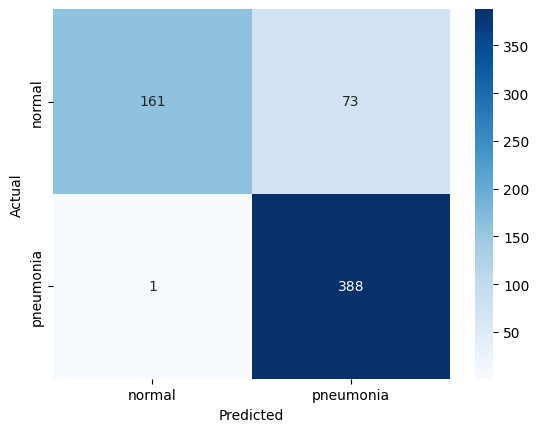

In [ ]:
labels = image_classes

cm = confusion_matrix(actual_classes, predicted_classes, labels=df_test1_stage1_results['true_class'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df_test1_stage1_results['true_class'].unique(),
            yticklabels=df_test1_stage1_results['true_class'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

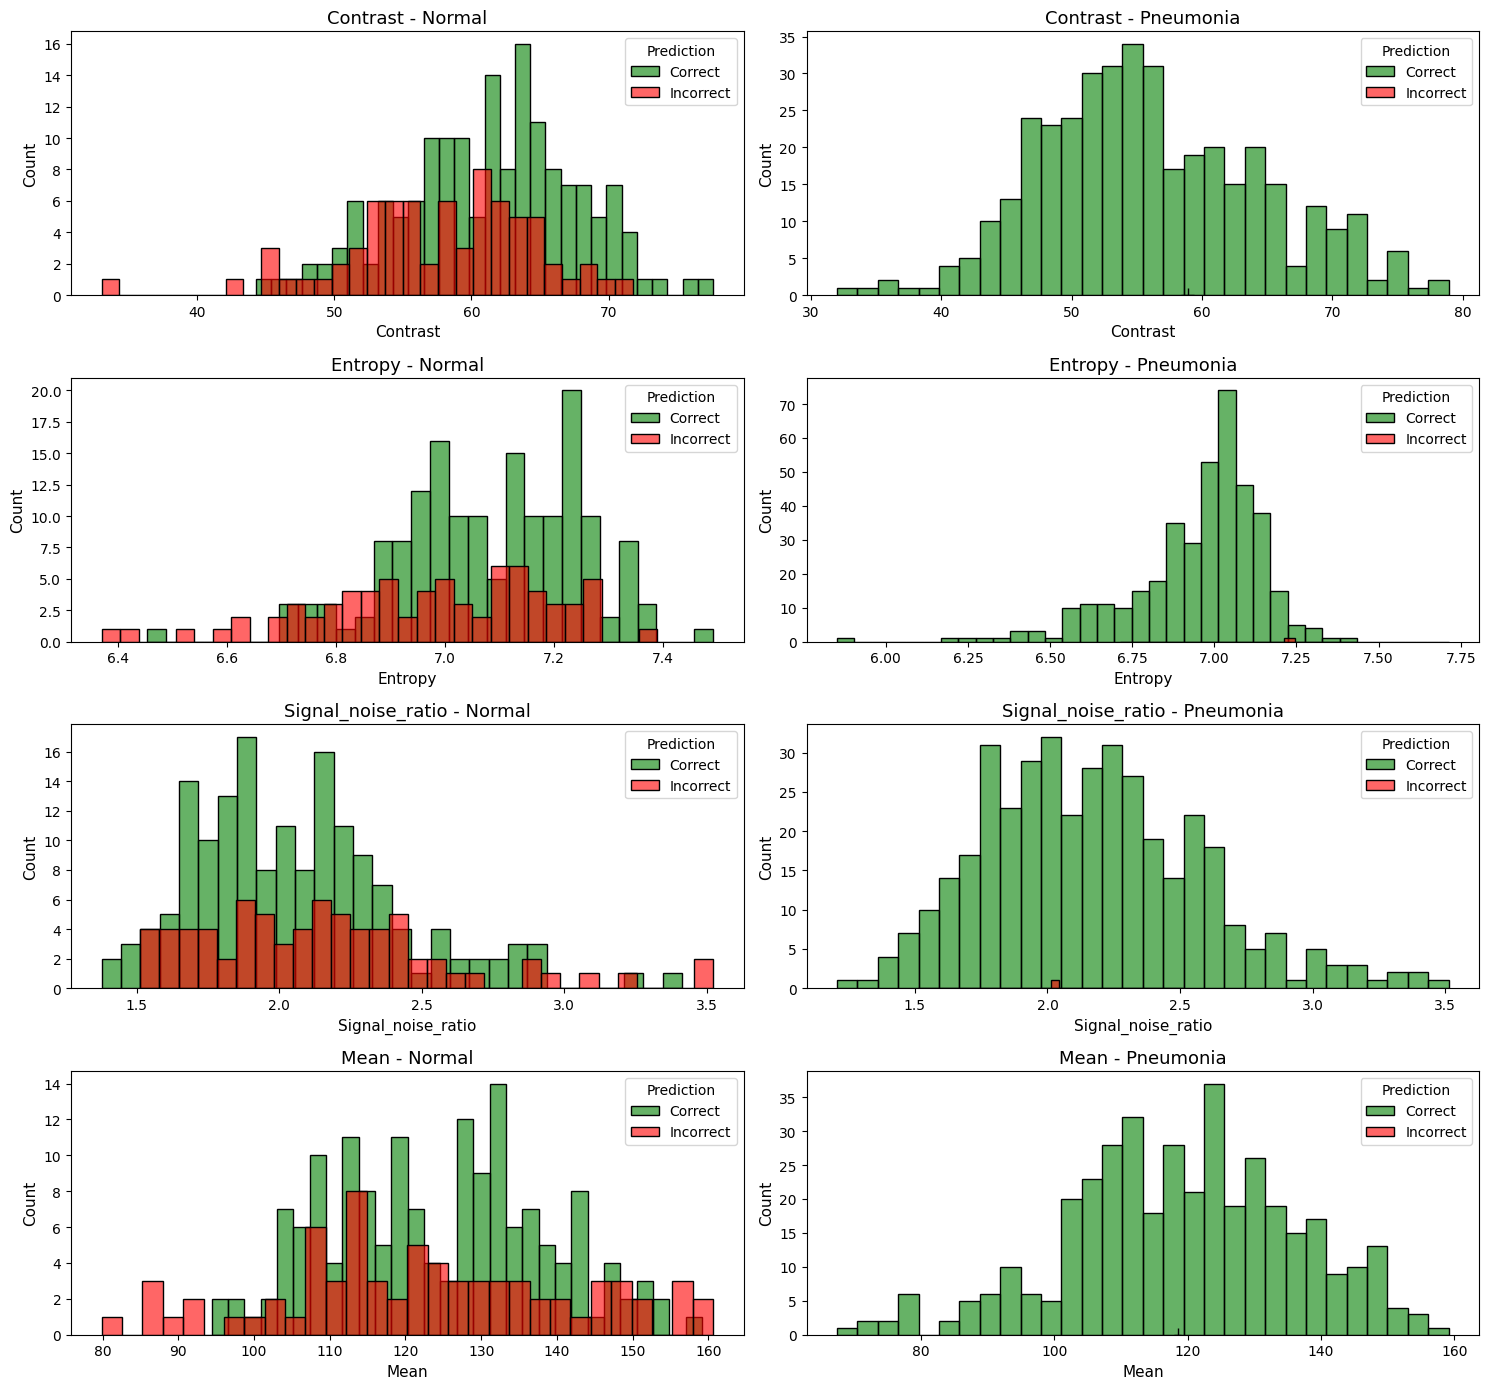

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

group_names = {1: 'Correct', 0: 'Incorrect'}
group_colors = {1: 'green', 0: 'red'}

fig, axes = plt.subplots(len(metrics), len(image_classes), figsize=(15, 14), sharex=False)

for i, metric in enumerate(metrics):
    for j, cls in enumerate(image_classes):
        ax = axes[i, j]
        for corr in [1, 0]:  # correct, incorrect
            vals = df_test1_stage1_results[
                (df_test1_stage1_results['image_class'] == cls) &
                (df_test1_stage1_results['correct'] == corr)
            ][metric].dropna()
            sns.histplot(
                vals,
                bins=30,
                ax=ax,
                color=group_colors[corr],
                alpha=0.6,
                linewidth=1,
                label=group_names[corr]
            )
        ax.set_title(f"{metric.capitalize()} - {cls.capitalize()}", fontsize=13)
        ax.set_xlabel(metric.capitalize(), fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.legend(title='Prediction')

plt.tight_layout()
plt.show()


##### Test Viral vs Bacterial Model

In [ ]:
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_test1_stage2 = df_training_set1[
    (df_training_set1['usage_type'] == 'test') &
    (df_training_set1['image_class'] == 'pneumonia')
].copy()

# Load trained bacterial/viral model
learn_set1_stage2 = load_learner(os.path.join(MODEL_PATH, 'set1_stage2_bacterial_viral_detector.pkl'))

test_dl_set1_stage2 = learn_set1_stage2.dls.test_dl(df_test1_stage2)

all_preds, _ = learn_set1_stage2.get_preds(dl=test_dl_set1_stage2)

pred_labels = [learn_set1_stage2.dls.vocab[i] for i in all_preds.argmax(dim=1)]
max_confidence = all_preds.max(dim=1).values.cpu().numpy()
true_labels = df_test1_stage2['image_subclass'].tolist()  # bacterial/viral

# Build results DataFrame
df_test1_stage2_results = df_test1_stage2.copy()
df_test1_stage2_results['predicted_class'] = pred_labels
df_test1_stage2_results['true_class'] = true_labels
df_test1_stage2_results['confidence'] = max_confidence
df_test1_stage2_results['correct'] = (df_test1_stage2_results['predicted_class'] == df_test1_stage2_results['true_class']).astype(int)

# Save results
df_test1_stage2_results.to_csv("test_set1_stage2_predictions_results.csv", index=False)



/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
actual_classes = df_test1_stage2_results['true_class']
predicted_classes = df_test1_stage2_results['predicted_class']
labels = sorted(list(set(actual_classes) | set(predicted_classes)))  # ensures all unique labels are used

accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes, average='macro', labels=labels)
recall = recall_score(actual_classes, predicted_classes, average='macro', labels=labels)
f1 = f1_score(actual_classes, predicted_classes, average='macro', labels=labels)

print(f"Accuracy: {accuracy:.3f}")
print(f"Macro Precision: {precision:.3f}")
print(f"Macro Recall: {recall:.3f}")
print(f"Macro F1-score: {f1:.3f}")


Accuracy: 0.910
Macro Precision: 0.912
Macro Recall: 0.896
Macro F1-score: 0.903


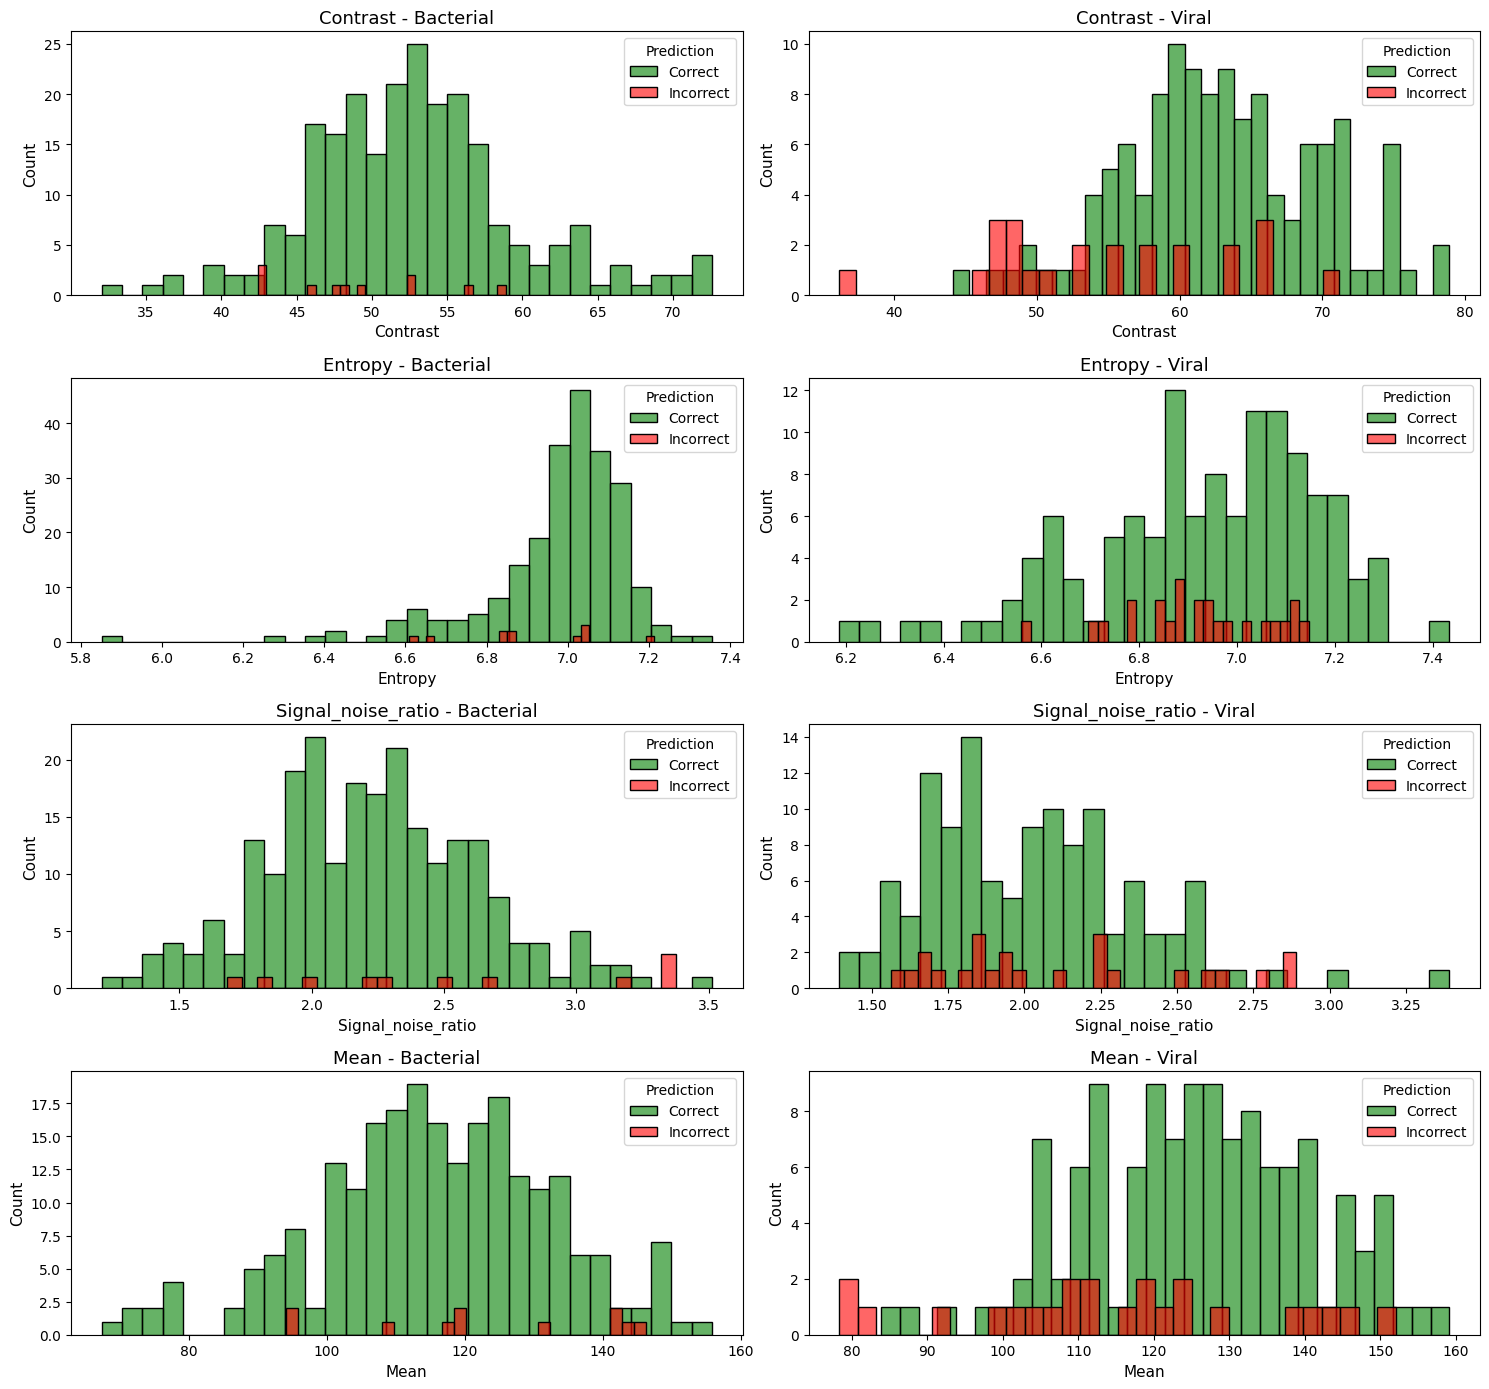

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

group_names = {1: 'Correct', 0: 'Incorrect'}
group_colors = {1: 'green', 0: 'red'}

fig, axes = plt.subplots(len(metrics), len(image_classes), figsize=(15, 14), sharex=False)

for i, metric in enumerate(metrics):
    for j, cls in enumerate(image_subclasses):
        ax = axes[i, j]
        for corr in [1, 0]:  # correct, incorrect
            vals = df_test1_stage2_results[
                (df_test1_stage2_results['image_subclass'] == cls) &
                (df_test1_stage2_results['correct'] == corr)
            ][metric].dropna()
            sns.histplot(
                vals,
                bins=30,
                ax=ax,
                color=group_colors[corr],
                alpha=0.6,
                linewidth=1,
                label=group_names[corr]
            )
        ax.set_title(f"{metric.capitalize()} - {cls.capitalize()}", fontsize=13)
        ax.set_xlabel(metric.capitalize(), fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.legend(title='Prediction')

plt.tight_layout()
plt.show()

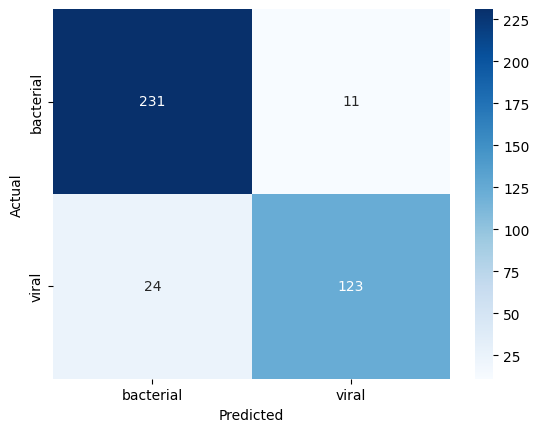

In [ ]:

# Get all present labels
labels = image_classes

cm = confusion_matrix(actual_classes, predicted_classes, labels=df_test1_stage2_results['true_class'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df_test1_stage2_results['true_class'].unique(),
            yticklabels=df_test1_stage2_results['true_class'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





#### Test Pneumonia Detection Model Set 2 - with CLAHE applied

##### Test Pneumoonia vs Normal Model

In [48]:
# Define the test set using df_training_set2
df_test_set2_stage1 = df_training_set2[df_training_set2['usage_type'] == 'test'].copy()

# Load the previously saved stage 1 model
learn_set2_stage1 = load_learner(os.path.join(MODEL_PATH, 'set2_pneumonia_detector-solid-cl20-88.pkl'))

# Create test dataloader
test_dl = learn_set2_stage1.dls.test_dl(df_test_set2_stage1)

# Get predictions
preds, _ = learn_set2_stage1.get_preds(dl=test_dl)
pred_labels = [learn_set2_stage1.dls.vocab[i] for i in preds.argmax(dim=1)]
max_confidence = preds.max(dim=1).values.cpu().numpy()
true_labels = df_test_set2_stage1['image_class'].tolist()


# Build results DataFrame
df_test_set2_stage1_results = df_test_set2_stage1.copy()
df_test_set2_stage1_results['predicted_class'] = pred_labels
df_test_set2_stage1_results['true_class'] = true_labels
df_test_set2_stage1_results['confidence'] = max_confidence
df_test_set2_stage1_results['correct'] = (df_test_set2_stage1_results['predicted_class']
                                      == df_test_set2_stage1_results['true_class']).astype(int)

# Save results
df_test_set2_stage1_results.to_csv("test_set1_stage1_predictions_results.csv", index=False)




/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [50]:
# Calculate Metrics

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels,average='binary', pos_label='pneumonia')
recall = recall_score(true_labels, pred_labels,average='binary', pos_label='pneumonia')
f1 = f1_score(true_labels, pred_labels,average='binary', pos_label='pneumonia')

print(f"Set 2 Stage 1 (Pneumonia Detection) Results:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Binary Precision: {precision:.3f}")
print(f"Binary Recall: {recall:.3f}")
print(f"Binary F1-score: {f1:.3f}")

Set 2 Stage 1 (Pneumonia Detection) Results:
Accuracy: 0.899
Binary Precision: 0.867
Binary Recall: 0.990
Binary F1-score: 0.925


In [ ]:
labels = image_classes

cm = confusion_matrix(true_labels, pred_labels, labels=
                      df_test_set2_stage1_results['true_class'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df_test_set2_stage1_results['true_class'].unique(),
            yticklabels=df_test_set2_stage1_results['true_class'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

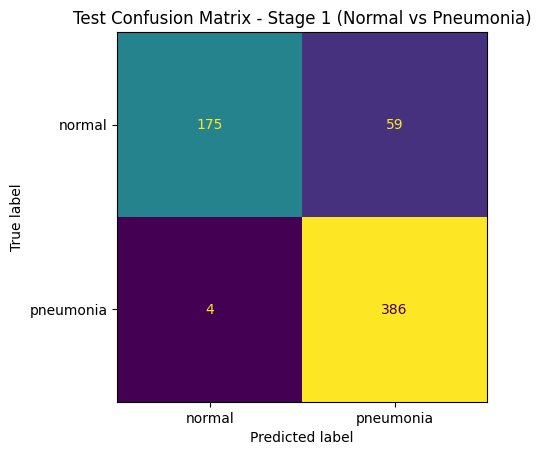

Confusion matrix (rows=true, cols=pred):
[[175  59]
 [  4 386]]


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Adjust names if your columns differ
y_true = df_test_set2_stage1_results["true_class"]
y_pred = df_test_set2_stage1_results["predicted_class"]

labels = ["normal", "pneumonia"]
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(colorbar=False)
plt.title("Test Confusion Matrix - Stage 1 (Normal vs Pneumonia)")
plt.show()

print("Confusion matrix (rows=true, cols=pred):")
print(cm)


In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# true_labels: list/array of "normal"/"pneumonia" for test set
label_to_int = {"normal": 0, "pneumonia": 1}
y_true = np.array([label_to_int[l] for l in true_labels])

# preds: tensor [N, 2] from learn.get_preds(dl=test_dl)
probs = preds[:, 1].cpu().numpy()   # pneumonia probability

best_f1 = 0.0
best_thresh = 0.5
results = []

for t in np.linspace(0.1, 0.9, 17):
    y_pred = (probs >= t).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    results.append((t, prec, rec, f1))
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print(f"Best F1: {best_f1:.3f} at threshold: {best_thresh:.2f}")
for t, prec, rec, f1 in results:
    print(f"thr={t:.2f}  precision={prec:.3f}  recall={rec:.3f}  F1={f1:.3f}")


Best F1: 0.963 at threshold: 0.90
thr=0.10  precision=0.810  recall=0.997  F1=0.894
thr=0.15  precision=0.822  recall=0.995  F1=0.900
thr=0.20  precision=0.834  recall=0.995  F1=0.908
thr=0.25  precision=0.836  recall=0.992  F1=0.907
thr=0.30  precision=0.843  recall=0.992  F1=0.912
thr=0.35  precision=0.848  recall=0.990  F1=0.914
thr=0.40  precision=0.862  recall=0.990  F1=0.921
thr=0.45  precision=0.865  recall=0.990  F1=0.923
thr=0.50  precision=0.867  recall=0.990  F1=0.925
thr=0.55  precision=0.875  recall=0.990  F1=0.929
thr=0.60  precision=0.887  recall=0.987  F1=0.934
thr=0.65  precision=0.893  recall=0.987  F1=0.938
thr=0.70  precision=0.895  recall=0.985  F1=0.938
thr=0.75  precision=0.908  recall=0.982  F1=0.943
thr=0.80  precision=0.918  recall=0.979  F1=0.948
thr=0.85  precision=0.943  recall=0.977  F1=0.960
thr=0.90  precision=0.952  recall=0.974  F1=0.963


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# 1. Map labels to 0/1 (1 = pneumonia)
label_to_int = {"normal": 0, "pneumonia": 1}
y_true = np.array([label_to_int[l] for l in true_labels])

# 2. Use the best threshold you found (0.90)
best_thresh = 0.2

# probs is the pneumonia probability (class index 1)
probs = preds[:, 1].cpu().numpy()
y_pred_bin = (probs >= best_thresh).astype(int)

# 3. Compute metrics with this threshold
prec = precision_score(y_true, y_pred_bin)
rec  = recall_score(y_true, y_pred_bin)
f1   = f1_score(y_true, y_pred_bin)

cm = confusion_matrix(y_true, y_pred_bin, labels=[0,1])
print("Confusion matrix at threshold 0.90 (rows=true, cols=pred):")
print(cm)
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


Confusion matrix at threshold 0.90 (rows=true, cols=pred):
[[157  77]
 [  2 388]]
Precision: 0.834, Recall: 0.995, F1: 0.908


In [ ]:
# Get raw preds on test set
preds, _ = learn_set2_stage1.get_preds(dl=test_dl)  # shape [N, 2]
probs = preds[:, 1].cpu().numpy()  # pneumonia prob

best_thresh = 0.90  # from your sweep

# Apply threshold
y_pred_bin = (probs >= best_thresh).astype(int)

# Map back to labels
int_to_label = {0: "normal", 1: "pneumonia"}
pred_labels_thr = [int_to_label[i] for i in y_pred_bin]

# Build results DataFrame with thresholded predictions
df_test_set2_stage1_results["predicted_class_thr"] = pred_labels_thr

# Recompute metrics at this operating point
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = df_test_set2_stage1_results["true_class"].values
y_true_bin = np.array([0 if l == "normal" else 1 for l in true_labels])

acc = accuracy_score(y_true_bin, y_pred_bin)
prec = precision_score(y_true_bin, y_pred_bin)
rec = recall_score(y_true_bin, y_pred_bin)
f1 = f1_score(y_true_bin, y_pred_bin)

print(f"Test metrics at threshold {best_thresh:.2f}:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")


Test metrics at threshold 0.90:
Accuracy: 0.954
Precision: 0.952
Recall: 0.974
F1-score: 0.963


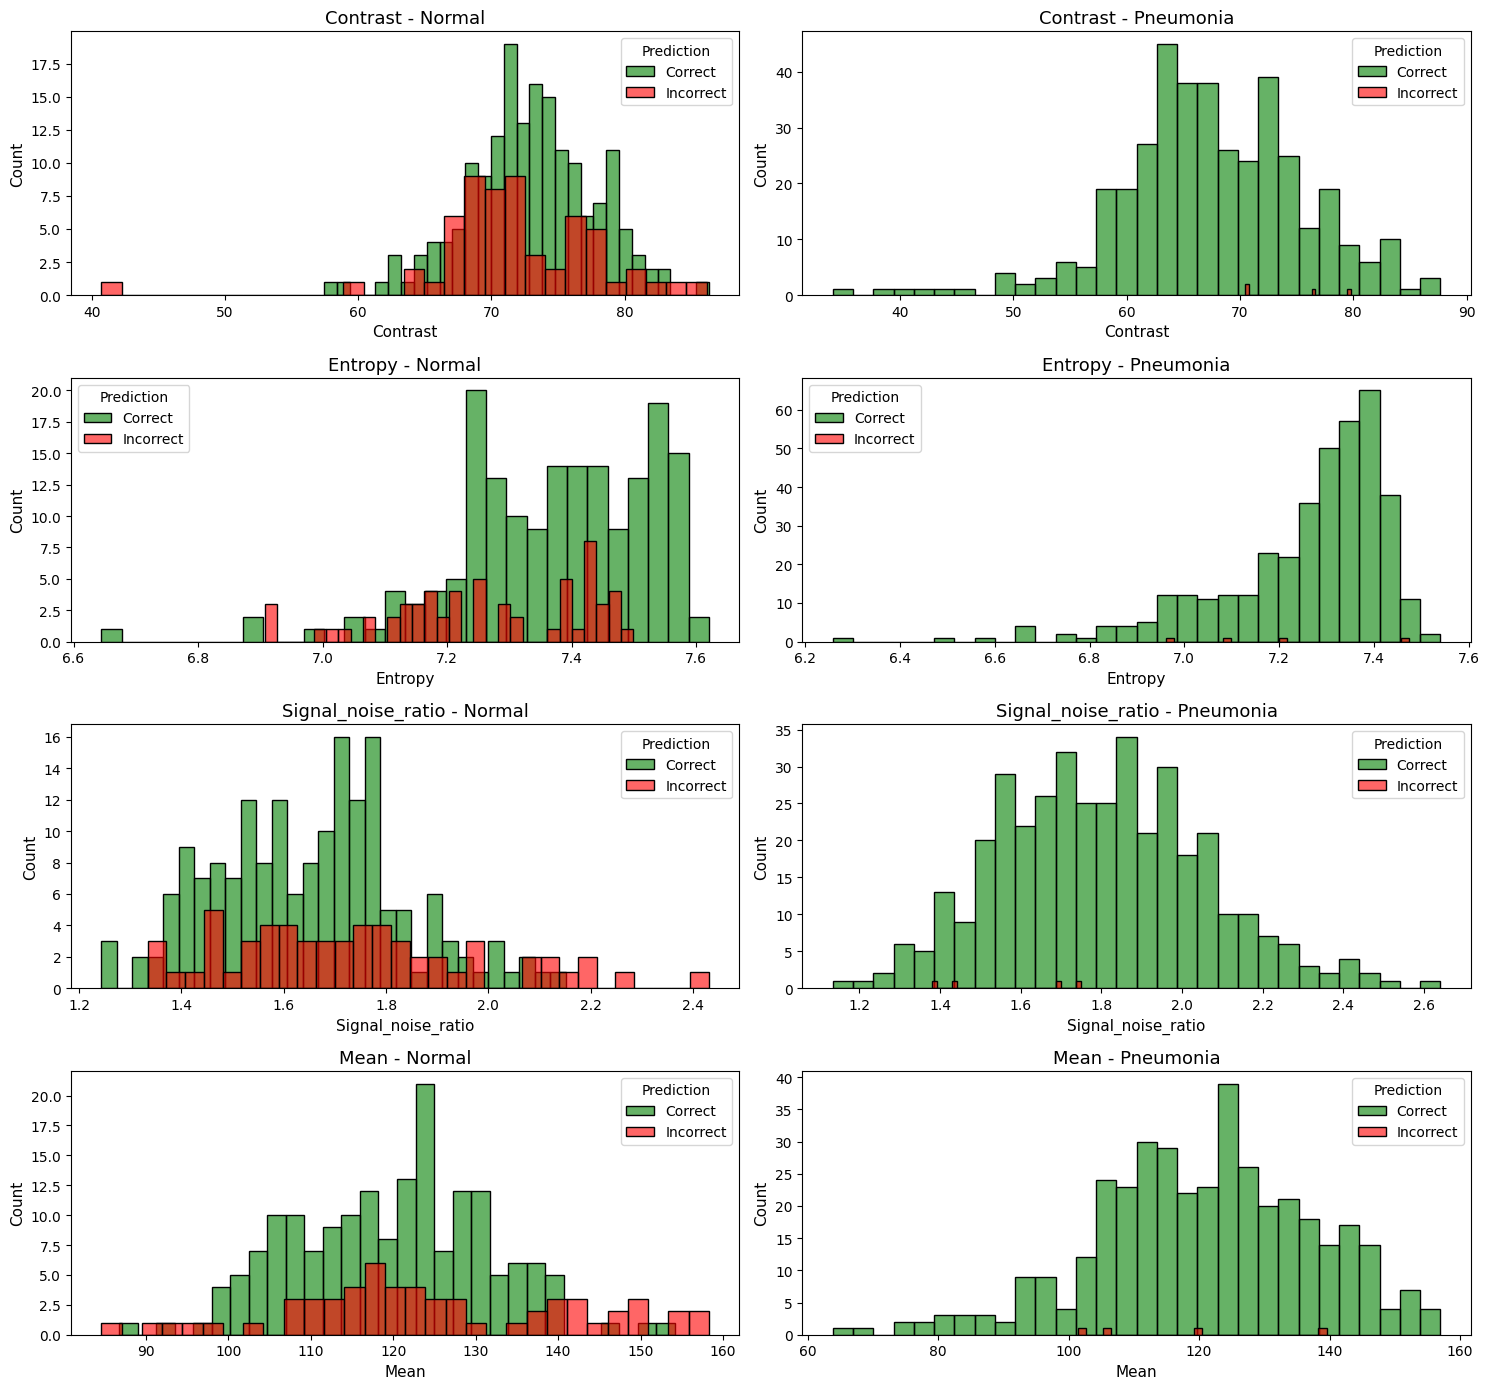

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

group_names = {1: 'Correct', 0: 'Incorrect'}
group_colors = {1: 'green', 0: 'red'}

fig, axes = plt.subplots(len(metrics), len(image_classes), figsize=(15, 14), sharex=False)

for i, metric in enumerate(metrics):
    for j, cls in enumerate(image_classes):
        ax = axes[i, j]
        for corr in [1, 0]:  # correct, incorrect
            vals = df_test_set2_stage1_results[
                (df_test_set2_stage1_results['image_class'] == cls) &
                (df_test_set2_stage1_results['correct'] == corr)
            ][metric].dropna()
            sns.histplot(
                vals,
                bins=30,
                ax=ax,
                color=group_colors[corr],
                alpha=0.6,
                linewidth=1,
                label=group_names[corr]
            )
        ax.set_title(f"{metric.capitalize()} - {cls.capitalize()}", fontsize=13)
        ax.set_xlabel(metric.capitalize(), fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.legend(title='Prediction')

plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, 0 to 623
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   orig_file_path       624 non-null    object 
 1   file_name            624 non-null    object 
 2   image_class          624 non-null    object 
 3   image_subclass       390 non-null    object 
 4   usage_type           624 non-null    object 
 5   predicted_class      624 non-null    object 
 6   true_class           624 non-null    object 
 7   confidence           624 non-null    float32
 8   correct              624 non-null    int64  
 9   predicted_class_thr  624 non-null    object 
dtypes: float32(1), int64(1), object(8)
memory usage: 51.2+ KB


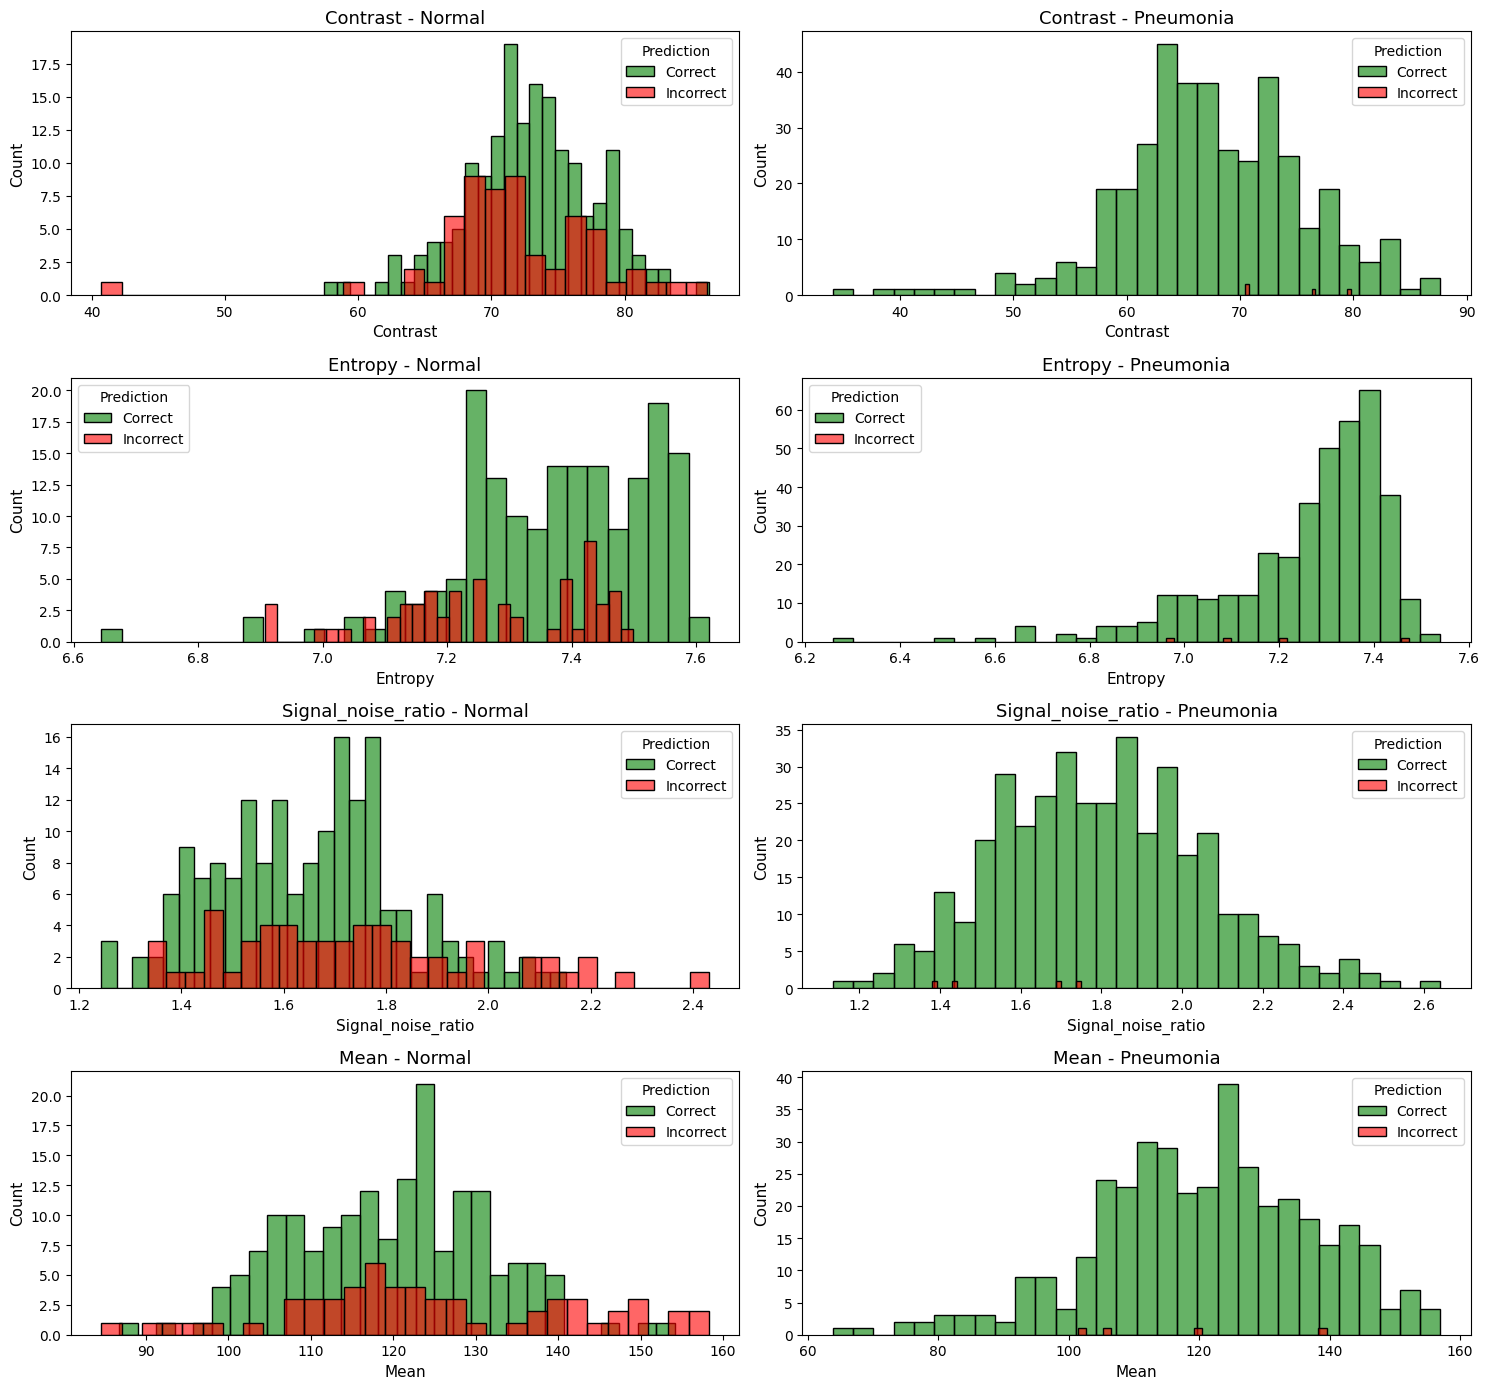

In [ ]:
metrics_file = os.path.join(DATA_PATH, 'xray_images_metrics.csv')
df_metrics = pd.read_csv(metrics_file)

df_test_set2_stage1_results_orig = df_test_set2_stage1_results.copy()
df_test_set2_stage1_results_orig = df_test_set2_stage1_results_orig.drop(
    columns=['contrast', 'entropy','mean', 'signal_noise_ratio', 'width', 'height'])
df_test_set2_stage1_results_orig.info()
df_test_set2_stage1_results_orig = pd.merge(df_test_set2_stage1_results_orig,
                                             df_metrics, on='orig_file_path',
                                            how='left')



group_names = {1: 'Correct', 0: 'Incorrect'}
group_colors = {1: 'green', 0: 'red'}

fig, axes = plt.subplots(len(metrics), len(image_classes), figsize=(15, 14), sharex=False)

for i, metric in enumerate(metrics):
    for j, cls in enumerate(image_classes):
        ax = axes[i, j]
        for corr in [1, 0]:  # correct, incorrect
            vals = df_test_set2_stage1_results[
                (df_test_set2_stage1_results['image_class'] == cls) &
                (df_test_set2_stage1_results['correct'] == corr)
            ][metric].dropna()
            sns.histplot(
                vals,
                bins=30,
                ax=ax,
                color=group_colors[corr],
                alpha=0.6,
                linewidth=1,
                label=group_names[corr]
            )
        ax.set_title(f"{metric.capitalize()} - {cls.capitalize()}", fontsize=13)
        ax.set_xlabel(metric.capitalize(), fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.legend(title='Prediction')

plt.tight_layout()
plt.show()

##### Test Viral vs Bacterial Model

In [ ]:


# Define the test set for Set 2 Stage 2 (Pneumonia only)
df_test_set2_stage2 = df_training_set2[
    (df_training_set2['usage_type'] == 'test') &
    (df_training_set2['image_class'] == 'pneumonia')
].copy()

# Load the previously saved stage 2 model
learn_set2_stage2 = load_learner(os.path.join(MODEL_PATH, 'set2_stage2_bacterial_viral_detector.pkl'))

# Create test dataloader
test_dl = learn_set2_stage2.dls.test_dl(df_test_set2_stage2)

# Get predictions
preds, _ = learn_set2_stage2.get_preds(dl=test_dl)
pred_labels = [learn_set2_stage2.dls.vocab[i] for i in preds.argmax(dim=1)]
true_labels = df_test_set2_stage2['image_subclass'].tolist()
max_confidence = preds.max(dim=1).values.cpu().numpy()
print(pred_labels)

# Build results DataFrame
df_test_set2_stage2_results = df_test_set2_stage2.copy()
df_test_set2_stage2_results['predicted_class'] = pred_labels
df_test_set2_stage2_results['true_class'] = true_labels
df_test_set2_stage2_results['confidence'] = max_confidence
df_test_set2_stage2_results['correct'] = (df_test_set2_stage2_results['predicted_class']
                                      == df_test_set2_stage2_results['true_class']).astype(int)

# Save results
df_test_set2_stage2_results.to_csv("test_set1_stage1_predictions_results.csv", index=False)







In [ ]:
# Metrics
actual_classes = df_test1_stage2_results['true_class']
predicted_classes = df_test1_stage2_results['predicted_class']


accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes, average='macro', labels=image_subclasses)
recall = recall_score(actual_classes, predicted_classes, average='macro', labels=image_subclasses)
f1 = f1_score(actual_classes, predicted_classes, average='macro', labels=image_subclasses)

print(f"Accuracy: {accuracy:.3f}")
print(f"Macro Precision: {precision:.3f}")
print(f"Macro Recall: {recall:.3f}")
print(f"Macro F1-score: {f1:.3f}")

In [ ]:
labels = image_classes

cm = confusion_matrix(true_labels, pred_labels, labels=image_subclasses)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=image_subclasses,
            yticklabels= image_subclasses)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Deployment

We can use the model to predict the animal type for an example image.

In [ ]:
# Pick a random image from the test set for demonstration
row = df_training_set1[df_training_set1['usage_type'] == 'test'].sample(1).iloc[0]
img_path = os.path.join(PROJECT_PATH, row['orig_file_path'])
img = PILImage.create(img_path)

# Load our best performing model (Set 1 Stratified Focal Loss)
learn = load_learner(os.path.join(MODEL_PATH, 'set1_pneumonia_focal_loss_stratified.pkl'))

prediction, _, probs = learn.predict(img)

print(f"True Class: {row['image_class']}")
print(f"Predicted: {prediction}")
print(f"Probability of Pneumonia: {probs[1].item():.6f}")
img.to_thumb(192)

##### Try the the model with pictures of dogs or cats that you have of your own or find online.

Load a new dog or cat image to test the model. Try a picture of my dog:

In [ ]:
# Download a sample Pneumonia X-ray
!wget -O sample_pneumonia.jpeg https://raw.githubusercontent.com/joshua-stroud/chest-x-ray-pneumonia/master/chest_xray/test/PNEUMONIA/person109_bacteria_526.jpeg

View the image

In [ ]:
img = PILImage.create('sample_pneumonia.jpeg')
img.to_thumb(300)

Predict the image class and plot the prediction

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the image in the first subplot
axes[0].imshow(img, cmap='gray')
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=learn.dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

<pre>



















</pre>

##### Let's see what it predicts for a picture of [grumpy cat](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg/250px-Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg) from Wikipedia

![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg/250px-Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg)



In [ ]:
# Download a sample Normal X-ray
!wget -O sample_normal.jpeg https://raw.githubusercontent.com/joshua-stroud/chest-x-ray-pneumonia/master/chest_xray/test/NORMAL/IM-0001-0001.jpeg

# create the image
img = PILImage.create('sample_normal.jpeg')

# plot the image
img.to_thumb(192)

In [ ]:
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the image in the first subplot
axes[0].imshow(img, cmap='gray')
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=learn.dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

Citation:
Waheed, S., Ghosh, S., & Gadekallu, T. R. (2022). Pre-processing methods in chest X-ray image classification. Frontiers in Medicine, 9, 898289. https://doi.org/10.3389/fmed.2022.898289

**Reasoning**:
Filter the comparative DataFrame to focus on cases where Dynamic CLAHE changed the outcome (improved or worsened), and visualize the distribution of image metrics for these groups using box plots to understand the impact of image characteristics.



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for differences
df_diff = df_comparative[df_comparative['Outcome'].isin(['Dynamic Improved', 'Dynamic Worsened'])].copy()

metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']

plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_diff, x='Outcome', y=metric)
    plt.title(f'{metric.capitalize()} Distribution by Outcome')

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter the comparative dataframe for changed outcomes
# We focus on where the model changed its mind: Improved vs Worsened
df_pairplot = df_comparative[df_comparative['Outcome'].isin(['Dynamic Improved', 'Dynamic Worsened'])].copy()

# 2. Define the metrics to analyze
metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']

# 3. Generate PairPlot
# This helps visualize if a combination of features separates the two groups
plt.figure(figsize=(12, 12))
g = sns.pairplot(
    df_pairplot,
    vars=metrics,
    hue='Outcome',
    palette={'Dynamic Improved': 'green', 'Dynamic Worsened': 'red'},
    diag_kind='kde',
    height=2.5
)

g.fig.suptitle('Multivariate Analysis: Image Characteristics vs. Model Outcome', y=1.02)
plt.show()

**Reasoning**:
I will filter the comparative DataFrame to identify images misclassified by both models, visualizing their metric distributions to understand shared difficulties.



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter for Common Errors (Both Incorrect)
df_errors_common = df_comparative[df_comparative['Outcome'] == 'Both Incorrect'].copy()

# 2. Define metrics
metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']

# 3. Generate PairPlot
plt.figure(figsize=(12, 12))
g = sns.pairplot(
    df_errors_common,
    vars=metrics,
    hue='image_class',
    diag_kind='kde',
    height=2.5,
    palette={'normal': 'blue', 'pneumonia': 'orange'}
)

g.fig.suptitle('Analysis of Common Errors: Metric Distribution for Hard Samples', y=1.02)
plt.show()

# 4. Print count
print(f"Total Common Errors (Hard Samples) analyzed: {len(df_errors_common)}")

CLAHE parameters (clipLimit, tileGridSize) are automatically selected for each image to maximize the output image's Shannon entropy. Higher entropy generally means richer local contrast and detail, thought to improve diagnostic quality.

The process involves either:

Running CLAHE with different parameter values and choosing the setting that yields the highest entropy, or

Using an empirically derived rule (threshold-based) from image entropy.

Example Implementation
Empirical criteria from the paper:

Input Entropy Range	CLAHE clipLimit	tileGridSize
< 5	3.5	(8, 8)
5–7	2.5	(8, 8)
> 7	1.5	(8, 8)
Sample code:

python
def get_clahe_params_entropy(entropy):
    if entropy < 5:
        return 3.5, (8, 8)    # Stronger enhancement for low-detail images
    elif entropy > 7:
        return 1.5, (8, 8)    # Subtle enhancement for already detailed images
    else:
        return 2.5, (8, 8)    # Moderate enhancement
You could further loop through a narrow band of clipLimit values around these settings and pick the one that maximizes output entropy, as in the original paper, but these empirically chosen thresholds worked robustly for clinical X-ray images in their tests.

Reference for your report or notebook:

Lim, H.-W., et al. (2017). Automatic x‐ray image contrast enhancement based on parameter optimization using entropy. Medical Physics, 44(5), 2212–2226. doi:10.1002/acm2.12172.

**Reasoning**:
Define the `find_optimal_clahe_params` function to calculate the optimal CLAHE clip limit by maximizing the Shannon entropy of the image's L-channel, as specified in the instructions.



In [ ]:
import cv2
import numpy as np
from skimage.measure import shannon_entropy

def find_optimal_clahe_params(img_rgb):
    """
    Iterates through a range of clipLimit values to find the one that maximizes
    the Shannon entropy of the L-channel in the LAB color space.
    """
    best_entropy = -1
    best_clip = 1.0

    # Define range of clip limits to test
    # Testing from 1.0 to 10.0 with step 0.5
    clip_limits = np.arange(1.0, 10.5, 0.5)

    for clip in clip_limits:
        # Convert to LAB
        lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)

        # Calculate Entropy
        ent = shannon_entropy(l_clahe)

        if ent > best_entropy:
            best_entropy = ent
            best_clip = clip

    return best_clip

In [ ]:
python code/e2e_stage1_comparison.py --balance-classes --clip-limit 2.5 --tile-size 10 10

In [ ]:
%run /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/code/e2e_stage1_comparison.py  --balance-classes --normal-weight 2.5 --grid-search --clip-limits 2.5 3.0 3.5 --tile-sizes "10,10" "12,12"





In [ ]:
%run /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/code/e2e_grayscale_clahe.py --balance-classes --normal-weight 2.5 --no-filter-quality


In [ ]:
%run /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/code/e2e_grayscale_clahe.py --balance-classes --normal-weight 2.5



In [ ]:
%run /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/code/e2e_grayscale_clahe_grid_search.py --balance-classes --normal-weight 2.5 --epochs 8

In [ ]:
%run /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/code/e2e_phase2_loss_optimization.py --select-ranks 2 8 22 --test-mode fast

## Appendix


In [56]:
from fastai.vision.all import *
import itertools, os, matplotlib.pyplot as plt
import pandas as pd

def sweep_clahe_on_misclassified_from_test_results(
    model_path,
    test_results_path,
    max_mis=12,
):
    #
    learn = load_learner(model_path)

    # 1) Load results
    df_res = pd.read_csv(test_results_path)

    mis_df = df_res[df_res['correct'] == 0].copy()
    print(f"{len(mis_df)} misclassified items in CSV")
    if len(mis_df) == 0:
        print("No misclassified items found; nothing to visualize.")
        return

    mis_df = mis_df.sort_values(by='confidence', ascending=False).head(max_mis)
    mis_samples = list(mis_df.itertuples(index=False))

    df_clean = pd.read_csv(DATA_PATH + '/df_clean.csv')

    clahe_configs = {
        'clip': {'Low': 1.0, 'Low-Med': 1.5, 'Med': 2.0, 'Med-High': 2.5, 'High': 3.0},
        'grid': {'Low': (8, 8), 'Low-Med': (10, 10), 'Med': (12, 12), 'Med-High': (14, 14), 'High': (16, 16)},
        'blur': {'Low': 9}
    }
    clahe_config_comb = list(itertools.product(
        clahe_configs['clip'].items(),
        clahe_configs['grid'].items(),
        clahe_configs['blur'].items()
    ))
    experiments = [
        {'clip': c_val, 'grid': g_val, 'blur': b_val,
         'name': f"C:{c_name} G:{g_name} B:{b_name}"}
        for (c_name, c_val), (g_name, g_val), (b_name, b_val) in clahe_config_comb
    ]
    print(f"Generated {len(experiments)} experimental combinations.")

    clahe_tfms = [EnsureGrayscale(), CLAHETransform(df_clean), ColormapTransform()]

    fig, axes = plt.subplots(
        len(experiments), len(mis_samples),
        figsize=(3 * len(mis_samples), 3.5 * len(experiments))
    )
    plt.subplots_adjust(hspace=0.5, wspace=0.15, top=0.97)
    fig.suptitle("CLAHE sweep on misclassified images", fontsize=16, y=0.99)

    for i, exp in enumerate(experiments):
        CLAHE_CLIP_LIMIT = exp['clip']
        CLAHE_TILE_GRID_SIZE = exp['grid']
        CLAHE_IMAGE_BLUR = exp['blur']

        clahe_tfm = learn.dls.after_item[1]
        clahe_tfm.clip_limit = CLAHE_CLIP_LIMIT
        clahe_tfm.tile_grid_size = CLAHE_TILE_GRID_SIZE
        clahe_tfm.medianBlur = CLAHE_IMAGE_BLUR

        for j, sample in enumerate(mis_samples):
            ax = axes[i, j] if len(experiments) > 1 else axes[j]

            img_path = os.path.join(PROJECT_PATH, sample.orig_file_path)
            img = PILImage.create(img_path); img.fname = img_path

            img_t = img.copy(); img_t.fname = img_path
            for tfm in clahe_tfms:
                img_t = tfm.encodes((img_t,))[0]

            pred, _, probs = learn.predict(img)
            conf = probs.max().item()
            res = f"{pred.capitalize()} (Conf: {conf:.4f})"

            pred_lbl = str(pred).lower()
            true_lbl = (sample.image_subclass
                        if getattr(sample, 'image_class', 'pneumonia') == 'pneumonia'
                        else 'normal')
            bg_color = 'green' if pred_lbl == true_lbl else 'red'

            ax.imshow(img_t); ax.axis('off')
            if j == 0:
                ax.text(-0.1, 0.5,
                        f"{exp['name']}\nClip:{CLAHE_CLIP_LIMIT}\nGrid:{CLAHE_TILE_GRID_SIZE}\nBlur:{CLAHE_IMAGE_BLUR}",
                        transform=ax.transAxes, ha='right', va='center',
                        fontsize=9, fontweight='bold')
            ax.set_title(true_lbl, fontsize=9)
            ax.text(0.5, -0.15, f"Pred: {res}", transform=ax.transAxes,
                    ha='center', va='top',
                    bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.9))

    plt.show()


model_path = os.path.join(MODEL_PATH, 'set2_pneumonia_detector-solid-cl20-88.pkl')
csv_path   = "test_set1_stage1_predictions_results.csv"  # note: your current filename

sweep_clahe_on_misclassified_from_csv(
    model_path=model_path,
    csv_path=csv_path,
    max_mis=12,          # or any other number of images you want
)



Output hidden; open in https://colab.research.google.com to view.